<a href="https://colab.research.google.com/github/sbathwal1999/MSE_Flight_Price_Prediction/blob/main/MSE_Flight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime,date
import missingno as msno
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore") 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import Files

In [2]:
eco = pd.read_csv('https://raw.githubusercontent.com/sbathwal1999/MSE_Flight_Price_Prediction/main/economy.csv')
bus = pd.read_csv('https://raw.githubusercontent.com/sbathwal1999/MSE_Flight_Price_Prediction/main/business.csv')

Merging the files into one

In [3]:
eco['class'] = 'Economy'
bus['class'] = 'Business'

In [4]:
df = eco.append(bus)

In [5]:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


In [6]:
print(f'The Dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The Dataset has 300261 rows and 12 columns.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300261 entries, 0 to 93486
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        300261 non-null  object
 1   airline     300261 non-null  object
 2   ch_code     300261 non-null  object
 3   num_code    300261 non-null  int64 
 4   dep_time    300261 non-null  object
 5   from        300261 non-null  object
 6   time_taken  300261 non-null  object
 7   stop        300261 non-null  object
 8   arr_time    300261 non-null  object
 9   to          300261 non-null  object
 10  price       300261 non-null  object
 11  class       300261 non-null  object
dtypes: int64(1), object(11)
memory usage: 29.8+ MB


#Feature Extraction

Date

In [8]:
#date
df['date'] = pd.to_datetime(df['date'],format = '%d-%m-%Y')

In [9]:
#Days Left
df['days_left'] = df['date'].apply(lambda x: str(x - datetime(2022,2,10)).split()[0]).astype('int64')

Airline

In [10]:
df['airline'].value_counts()/df.shape[0]*100

Vistara      42.582620
Air India    26.941228
Indigo       14.360839
GO FIRST      7.718951
AirAsia       5.361336
SpiceJet      3.001056
StarAir       0.020316
Trujet        0.013655
Name: airline, dtype: float64

In [11]:
def cleaned_airline(x):
  word = []
  for char in x:
    char = char.replace(' ','_')
    word.append(char)
  x = ''.join(word)
  if (x == 'StarAir')|(x=='Trujet'):
    x = np.nan
  elif (x=='GO FIRST'):
      x = x.title()
  return x

In [12]:
df['airline'] = df['airline'].apply(cleaned_airline)

Flight

In [13]:
df['flight'] = df['ch_code'] + '-' + df['num_code'].apply(lambda x: str(x))

In [14]:
df['dep_time'] = pd.to_datetime(df['dep_time'])
df['arr_time'] = pd.to_datetime(df['arr_time'])

Departure and Arrival Time

Breaking a day into bins:
1. **Early Morning**: 4 AM to 8 AM
2. **Morning**: 8 AM to 12 Noon
3. **Afternoon**: 12 Noon to 4 PM
5. **Evening**: 4 PM to 8 PM
6. **Night**: 8 PM to 12 Midnight
7. **Late Night**: 12 Midnight to 4AM

In [15]:
tod = ['Late_Night','Early_Morning','Morning','Afternoon','Evening','Night']

In [16]:
df['departure_time'] = pd.cut(df['dep_time'].apply(lambda x : x.hour + round(x.minute/60,2)),bins=[0,4,8,12,16,20,24],labels=tod).astype('O')
df['arrival_time'] = pd.cut(df['arr_time'].apply(lambda x : x.hour + round(x.minute/60,2)),bins=[0,4,8,12,16,20,24],labels=tod).astype('O')

In [17]:
df['departure_time'].value_counts()/df.shape[0]*100

Morning          23.708041
Early_Morning    22.251641
Evening          21.682137
Night            15.998082
Afternoon        15.925145
Late_Night        0.434955
Name: departure_time, dtype: float64

In [18]:
df['arrival_time'].value_counts()/df.shape[0]*100

Night            30.493138
Evening          26.094631
Morning          20.909142
Afternoon        12.705280
Early_Morning     5.134866
Late_Night        4.662943
Name: arrival_time, dtype: float64

Source and Destination City

In [19]:
df['from'].value_counts()/df.shape[0]*100

Delhi        20.430559
Mumbai       20.283353
Bangalore    17.353569
Kolkata      15.435571
Hyderabad    13.608161
Chennai      12.888787
Name: from, dtype: float64

In [20]:
df['to'].value_counts()/df.shape[0]*100

Mumbai       19.685873
Delhi        19.103713
Bangalore    17.022524
Kolkata      16.497314
Hyderabad    14.246272
Chennai      13.444303
Name: to, dtype: float64

In [21]:
df['source_city'] = df['from']
df['destination_city'] = df['to'] 

Duration

In [22]:
def duration(x):
  try:
    s=''
    if 'h' in x:
      if int(x.split('h')[0])>23:
        s=s+str(int(x.split('h')[0])//24) + 'd ' + str(int(x.split('h')[0])%24) +'h '
      else:
        s=s+'0d ' + x.split('h')[0]+'h '
    else:
      s=s+'0d 0h '
    if 'm' in x:
      if 'h' in x:
        s=s+x.split('h')[1].split('m')[0].strip() + 'm'
      else:
        s=s+x.split('m')[0].strip() + 'm'
    else:
      s=s+'0m'
    s = round(int(s.split('d')[0])*24 + int(s.split('d')[1].split('h')[0]) + int(s.split('d')[1].split('h')[1].split('m')[0])/60,2)
    return s
  except:
    return np.nan

In [23]:
df['duration'] = df['time_taken'].apply(duration)

Stops

In [24]:
def stop(x):
  if x.split('-')[0] == 'non':
    return 'zero'
  elif x.split('-')[0] == '1':
    return 'one'
  else:
    return 'two_or_more'

In [25]:
df['stops'] = df['stop'].apply(stop)

Price

In [26]:
df['price'] = df['price'].apply(lambda x: int(re.sub(',','',x)))

Class

In [27]:
df['class'].value_counts()/df.shape[0]*100

Economy     68.864754
Business    31.135246
Name: class, dtype: float64

#Data Cleaning

Checking for Null Values

In [28]:
df.isnull().sum()

date                  0
airline             102
ch_code               0
num_code              0
dep_time              0
from                  0
time_taken            0
stop                  0
arr_time              0
to                    0
price                 0
class                 0
days_left             0
flight                0
departure_time        0
arrival_time          0
source_city           0
destination_city      0
duration              4
stops                 0
dtype: int64

<function matplotlib.pyplot.show>

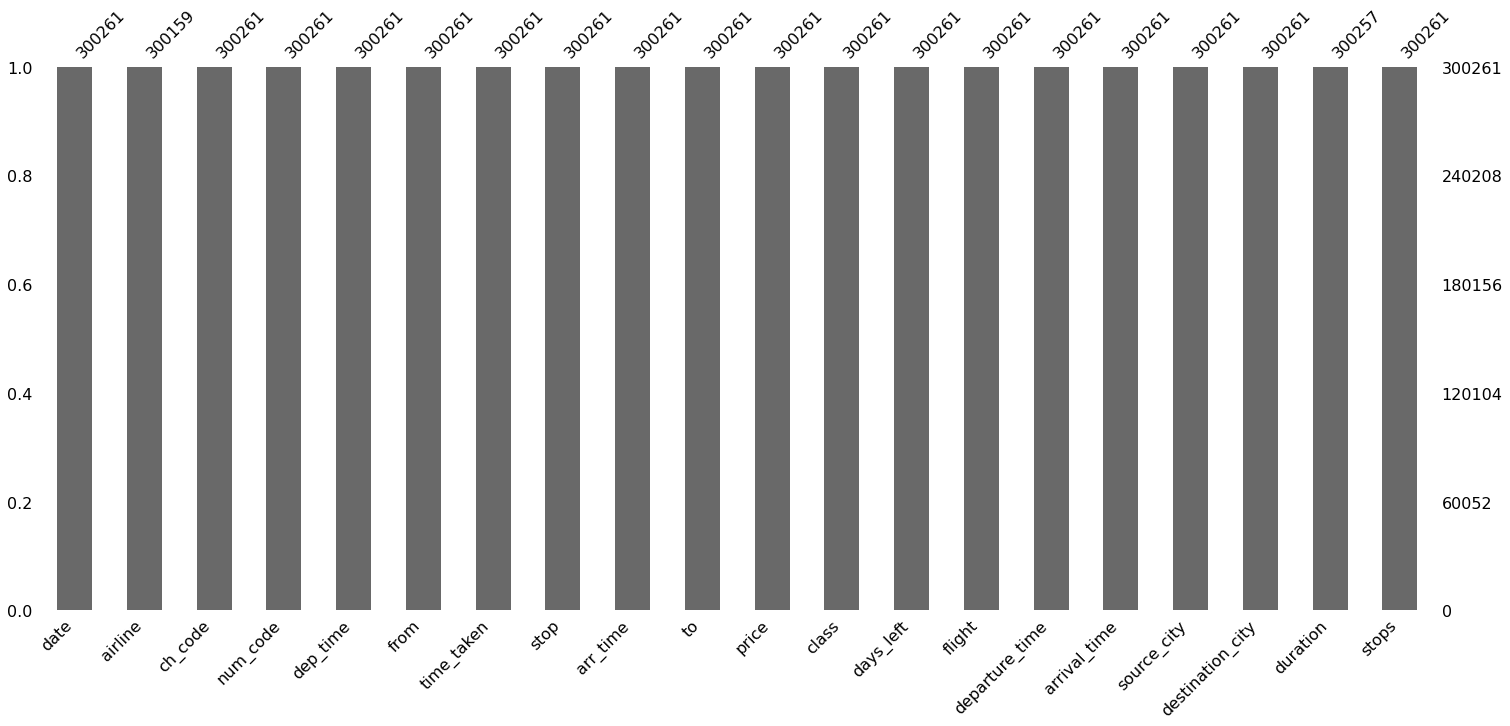

In [29]:
msno.bar(df)
plt.show

In [30]:
df.isnull().mean()*100

date                0.000000
airline             0.033970
ch_code             0.000000
num_code            0.000000
dep_time            0.000000
from                0.000000
time_taken          0.000000
stop                0.000000
arr_time            0.000000
to                  0.000000
price               0.000000
class               0.000000
days_left           0.000000
flight              0.000000
departure_time      0.000000
arrival_time        0.000000
source_city         0.000000
destination_city    0.000000
duration            0.001332
stops               0.000000
dtype: float64

Dropping Null values

In [31]:
df.dropna(inplace=True)

In [32]:
df.duplicated().sum()

2

Dropping Duplicates

In [33]:
df = df.drop_duplicates()

In [34]:
df.reset_index(drop = 'index',inplace=True)

In [35]:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,days_left,flight,departure_time,arrival_time,source_city,destination_city,duration,stops
0,2022-02-11,SpiceJet,SG,8709,2022-02-26 18:55:00,Delhi,02h 10m,non-stop,2022-02-26 21:05:00,Mumbai,5953,Economy,1,SG-8709,Evening,Night,Delhi,Mumbai,2.17,zero
1,2022-02-11,SpiceJet,SG,8157,2022-02-26 06:20:00,Delhi,02h 20m,non-stop,2022-02-26 08:40:00,Mumbai,5953,Economy,1,SG-8157,Early_Morning,Morning,Delhi,Mumbai,2.33,zero
2,2022-02-11,AirAsia,I5,764,2022-02-26 04:25:00,Delhi,02h 10m,non-stop,2022-02-26 06:35:00,Mumbai,5956,Economy,1,I5-764,Early_Morning,Early_Morning,Delhi,Mumbai,2.17,zero
3,2022-02-11,Vistara,UK,995,2022-02-26 10:20:00,Delhi,02h 15m,non-stop,2022-02-26 12:35:00,Mumbai,5955,Economy,1,UK-995,Morning,Afternoon,Delhi,Mumbai,2.25,zero
4,2022-02-11,Vistara,UK,963,2022-02-26 08:50:00,Delhi,02h 20m,non-stop,2022-02-26 11:10:00,Mumbai,5955,Economy,1,UK-963,Morning,Morning,Delhi,Mumbai,2.33,zero


#Feature Selection

In [36]:
data = df.copy()

In [37]:
df = df[['airline','flight','source_city','departure_time','stops','arrival_time','destination_city','class','duration','days_left','price']]

In [38]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


# Feature Datatype

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [40]:
categorical_features = [x for x in df.columns if df[x].dtypes == 'object']
numerical_features = [x for x in df.columns if df[x].dtypes != 'object']
continuous_features = [x for x in numerical_features if df[x].nunique()>31]
discrete_features = [x for x in numerical_features if x not in continuous_features]

In [41]:
print(f'There are {len(categorical_features)} categorical features in dataset')
print('Categorical features:',categorical_features)

There are 8 categorical features in dataset
Categorical features: ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']


In [42]:
print(f'There are {len(continuous_features)} continuous numerical features in dataset')
print('Numerical features:',continuous_features)

There are 3 continuous numerical features in dataset
Numerical features: ['duration', 'days_left', 'price']


In [43]:
print(f'There are {len(discrete_features)} discrete numerical features in dataset')
print('Numerical features:',discrete_features)

There are 0 discrete numerical features in dataset
Numerical features: []


# Exploratory Data Analysis

In [44]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [45]:
df.describe(include = 'O')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class
count,300153,300153,300153,300153,300153,300153,300153,300153
unique,6,1561,6,6,3,6,6,2
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy
freq,127859,3235,61343,71146,250863,91538,59097,206666


## Univariate Analysis

In [46]:
#Airline
df['airline'].value_counts()

Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64

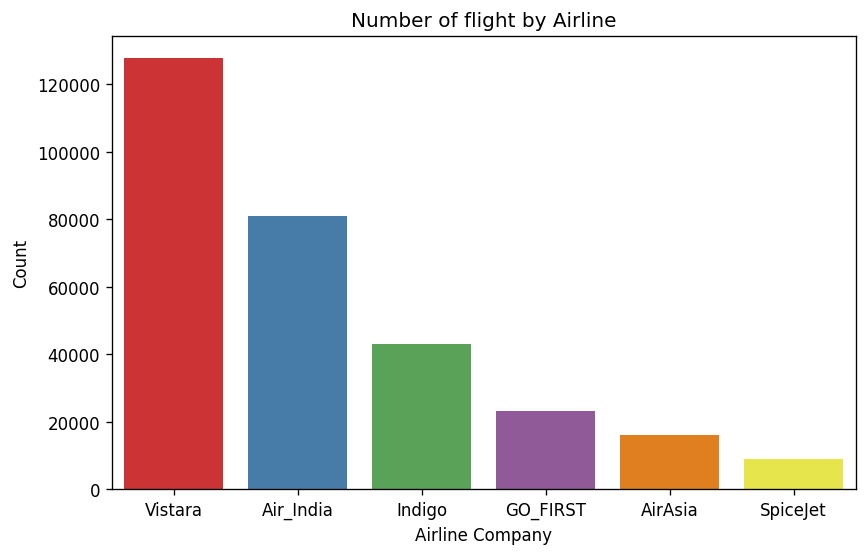

In [47]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df['airline'].value_counts(),x=df['airline'].value_counts().index,palette = 'Set1')
plt.xlabel('Airline Company')
plt.ylabel('Count')
plt.title('Number of flight by Airline')
plt.show()

Within a 50-day period, Vistara has the most number of flight .<br>
StarAir and Trujet are minor airline companies with only 61 and 41 flights respectively.

In [48]:
#Departure Time
df['departure_time'].value_counts()

Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: departure_time, dtype: int64

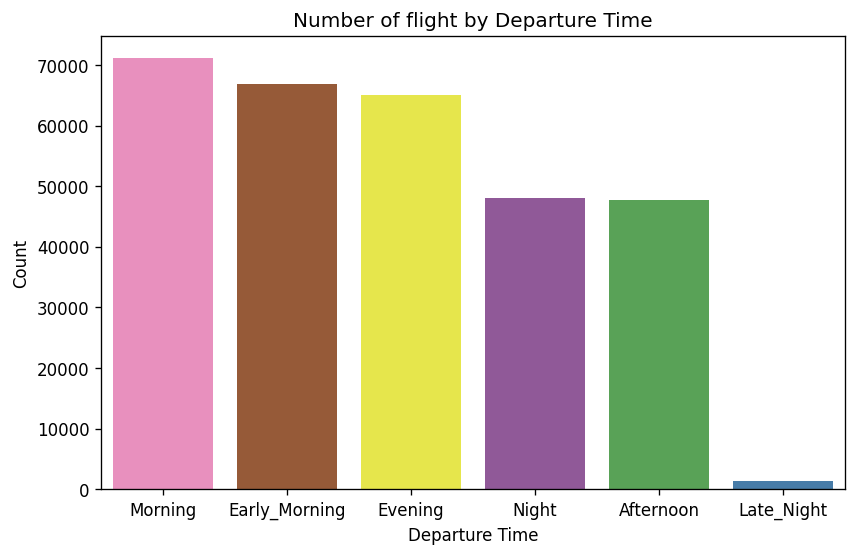

In [49]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df['departure_time'].value_counts(),x=df['departure_time'].value_counts().index,palette = 'Set1_r')
plt.xlabel('Departure Time')
plt.ylabel('Count')
plt.title('Number of flight by Departure Time')
plt.show()

From the graph it can be said that passengers do not prefer to travel at Late Night.<br>


In [50]:
#Arrival Time
data['arrival_time'].value_counts()

Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: arrival_time, dtype: int64

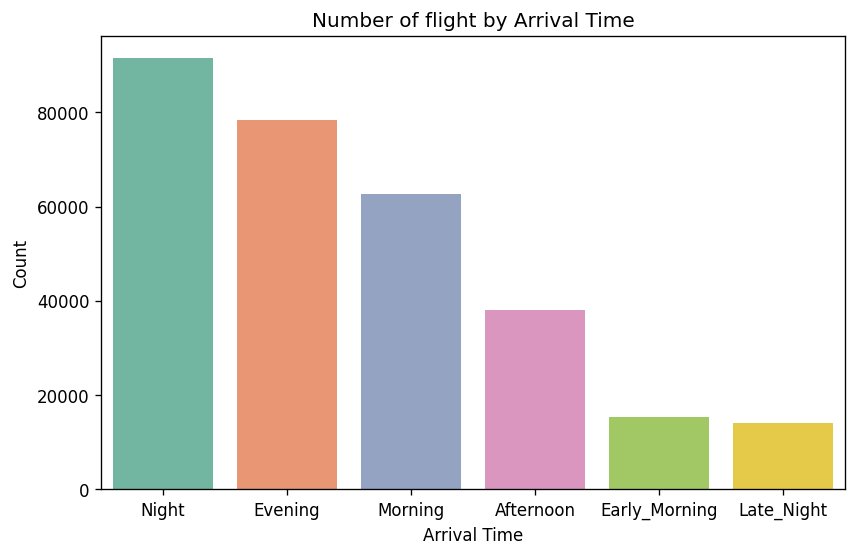

In [51]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = data['arrival_time'].value_counts(),x=data['arrival_time'].value_counts().index,palette = 'Set2')
plt.xlabel('Arrival Time')
plt.ylabel('Count')
plt.title('Number of flight by Arrival Time')
plt.show()

From the graph it can be said that passengers do not prefer to travel at Late Night.<br>Airlines may use this time for maintenance.

In [52]:
#Source City
df['source_city'].value_counts()

Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64

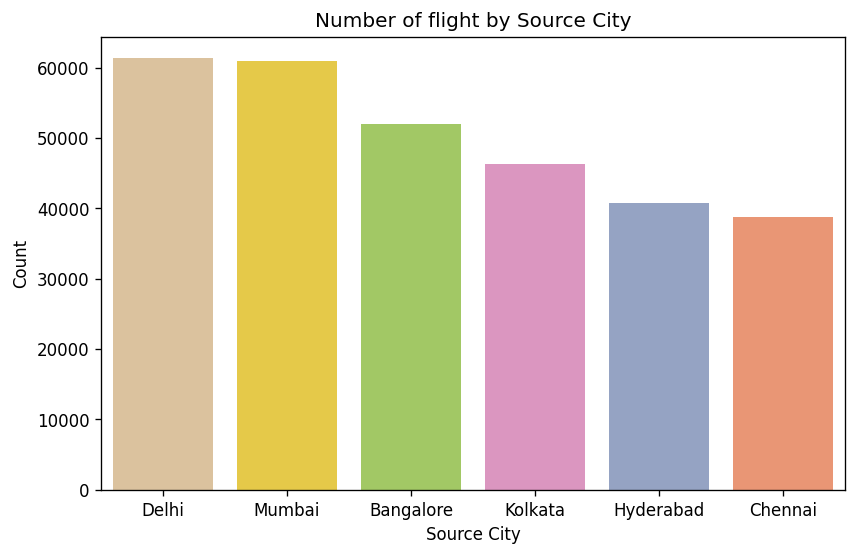

In [53]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df['source_city'].value_counts(),x=df['source_city'].value_counts().index,palette = 'Set2_r')
plt.xlabel('Source City')
plt.ylabel('Count')
plt.title('Number of flight by Source City')
plt.show()

Large number of flight originate from Delhi and Mumbai

In [54]:
#Destination City
df['destination_city'].value_counts()

Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: destination_city, dtype: int64

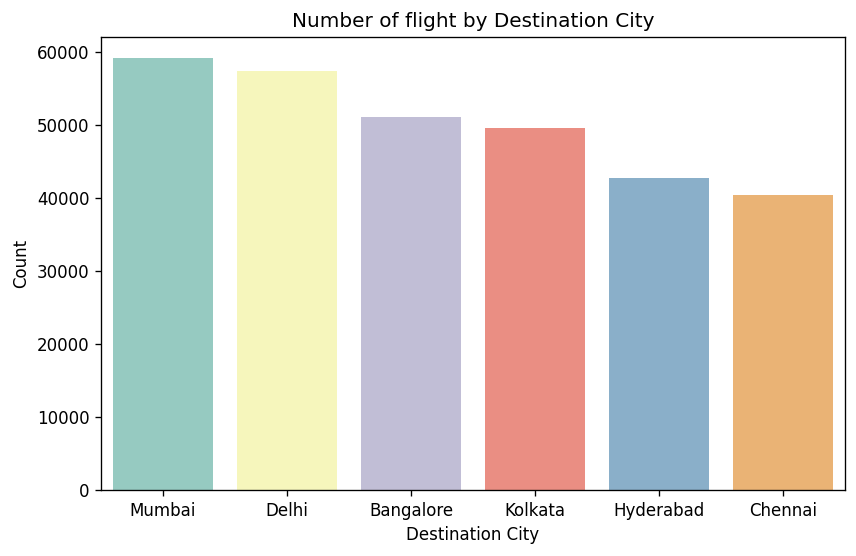

In [55]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df['destination_city'].value_counts(),x=df['destination_city'].value_counts().index,palette = 'Set3')
plt.xlabel('Destination City')
plt.ylabel('Count')
plt.title('Number of flight by Destination City')
plt.show()

According to the graphs above, Delhi and Mumbai have the busiest airports, while Chennai has the least. 

In [56]:
#Number of stop
df['stops'].value_counts()

one            250863
zero            36004
two_or_more     13286
Name: stops, dtype: int64

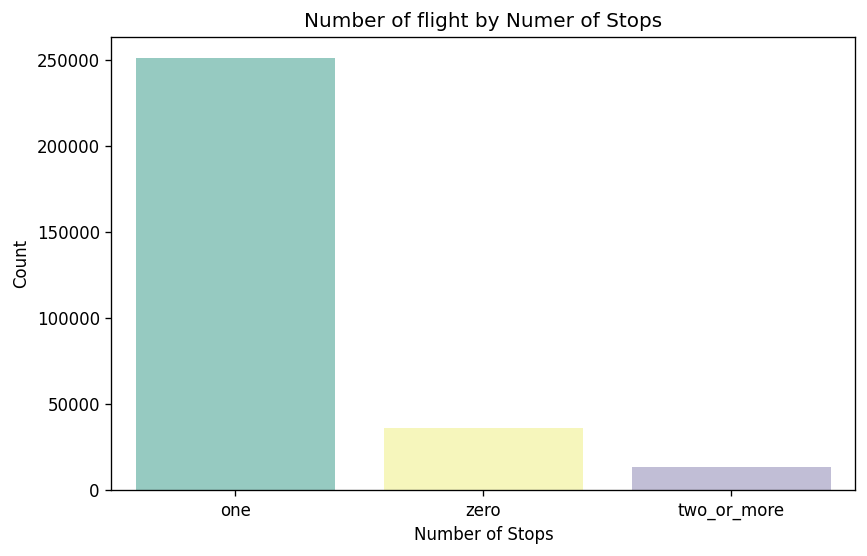

In [57]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df['stops'].value_counts(),x=df['stops'].value_counts().index,palette = 'Set3')
plt.xlabel('Number of Stops')
plt.ylabel('Count')
plt.title('Number of flight by Numer of Stops')
plt.show()

Between the origin and destination cities, most flights make at least one stop. 

In [58]:
#Class
df['class'].value_counts()

Economy     206666
Business     93487
Name: class, dtype: int64

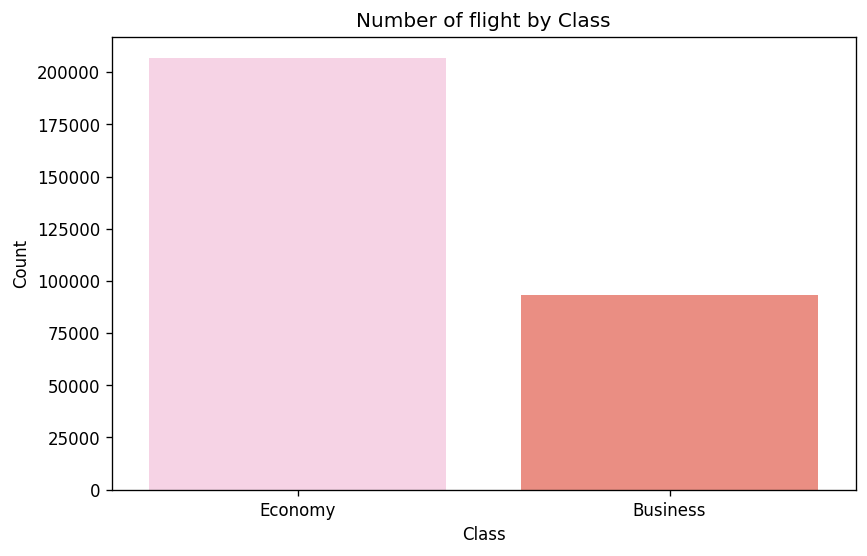

In [59]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df['class'].value_counts(),x=df['class'].value_counts().index,palette = 'Set3_r')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of flight by Class')
plt.show()

In India, the majority of travel is done in economy class. 

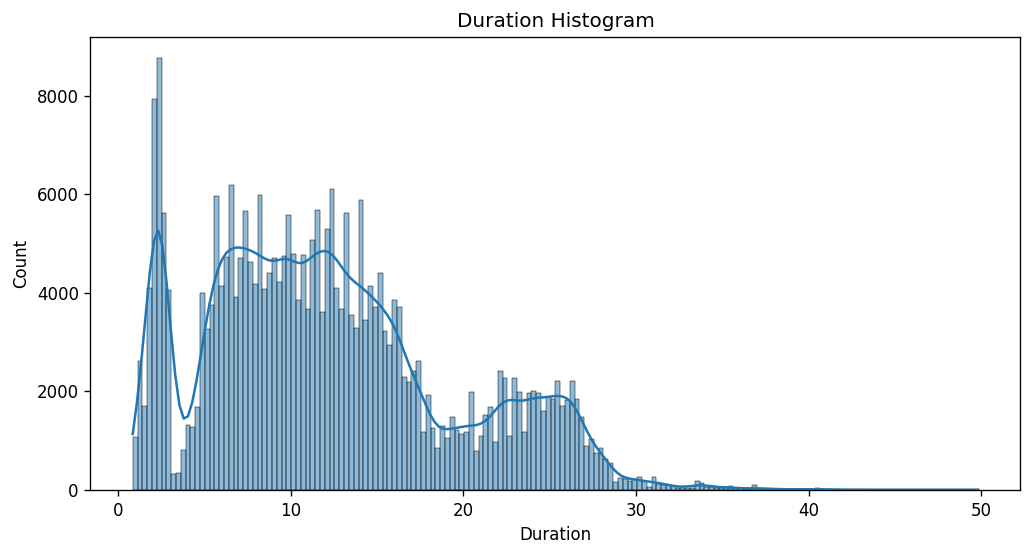

In [60]:
#Duration
plt.figure(figsize=(10,5),dpi=120)
sns.histplot(df['duration'],kde=True)
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Duration Histogram')
plt.show()

In [61]:
df['duration'].describe()

count    300153.000000
mean         12.221021
std           7.191997
min           0.830000
25%           6.830000
50%          11.250000
75%          16.170000
max          49.830000
Name: duration, dtype: float64

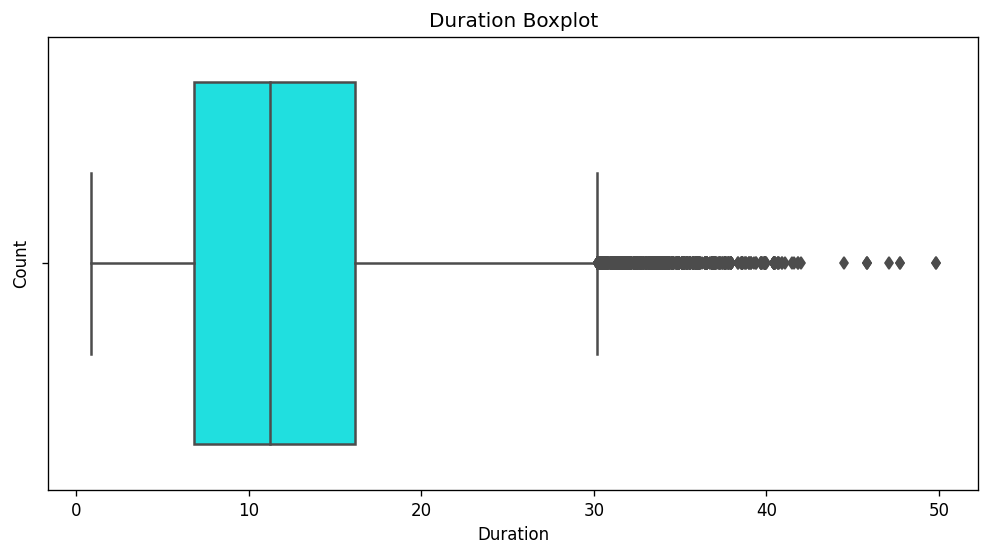

In [62]:
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(x = 'duration', data = df,color='cyan')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Duration Boxplot')
plt.show()

In [63]:
#flight
data['flight'].value_counts()

UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: flight, Length: 1561, dtype: int64

In [64]:
air_flight = []
def uniq_flight(x,data):
  global air_flight
  air_flight.append(data[data['airline']==x]['flight'].nunique())

In [65]:
for air in data['airline'].value_counts().index:
  uniq_flight(air,data)

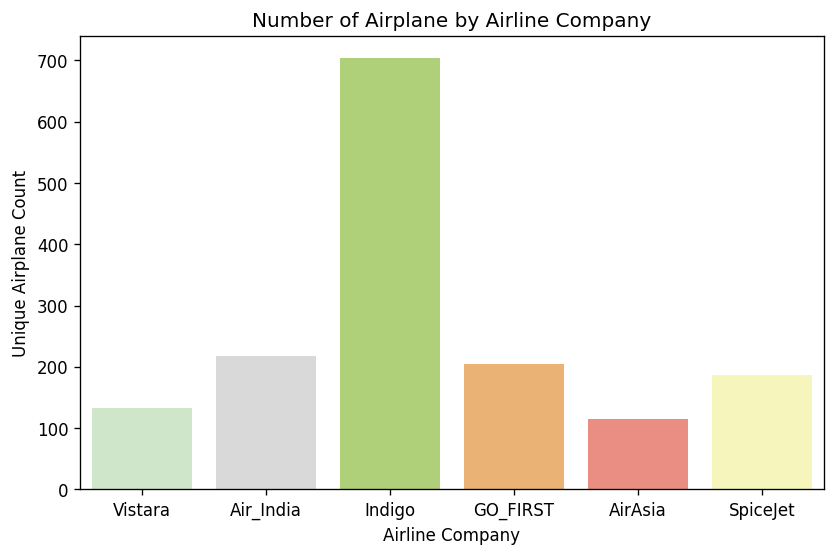

In [66]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = air_flight,x=df['airline'].value_counts().index,palette = 'Set3_r')
plt.xlabel('Airline Company')
plt.ylabel('Unique Airplane Count')
plt.title('Number of Airplane by Airline Company')
plt.show()

Indigo has the largest number of planes that operate between cities.


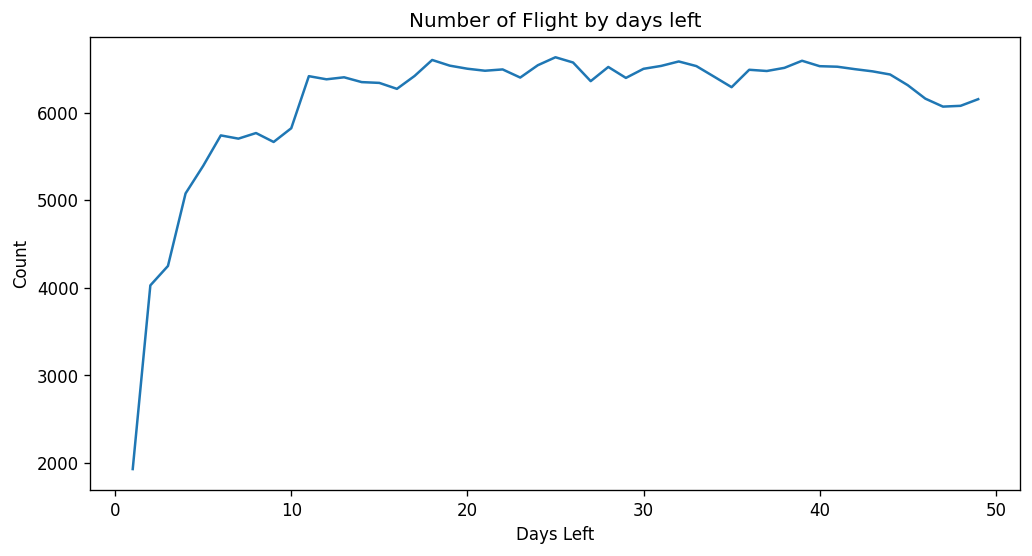

In [67]:
#Days Left
plt.figure(figsize=(10,5),dpi=120)
sns.lineplot(y=df.groupby('days_left').count()['airline'],x=df.reset_index().groupby('days_left').count()['airline'].index)
plt.xlabel('Days Left')
plt.ylabel('Count')
plt.title('Number of Flight by days left')
plt.show()

A recent flight may have been booked, resulting in a lower number.
Approximately 6000 flights travel through India's top six cities on a daily basis. 

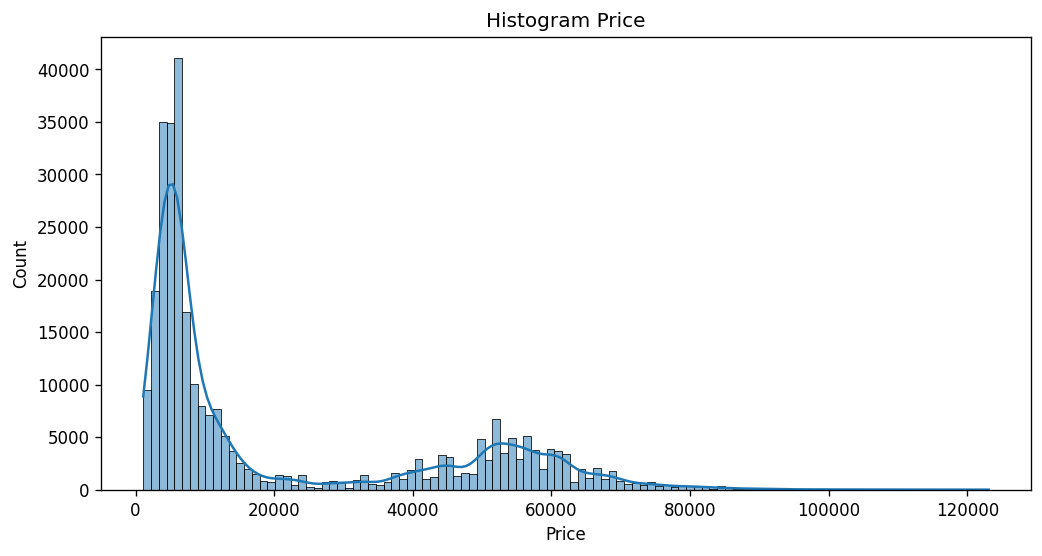

In [68]:
#price
plt.figure(figsize=(10,5),dpi=120)
sns.histplot(df['price'],kde=True)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram Price')
plt.show()

The graph is right skewed as expected, indicating that most passengers choose economical travel than exotic travel. 

In [69]:
df['price'].describe()

count    300153.000000
mean      20889.660523
std       22697.767366
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

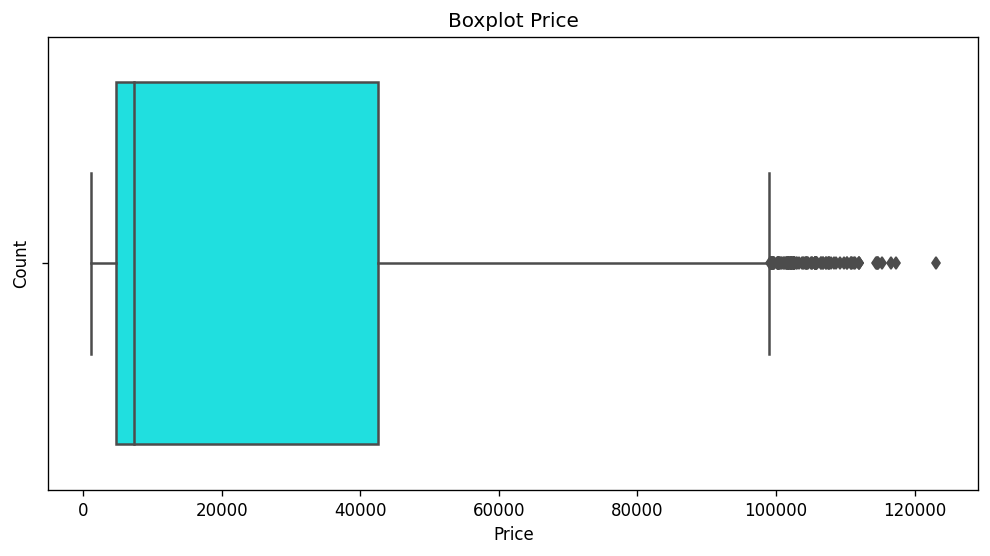

In [70]:
#price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(df['price'],color='cyan')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Boxplot Price')
plt.show()

In India, most flights cost between 5000 and 40000 rupees.
With half of the flights costing less than 7500 rupees. 

## Bivariate Analysis

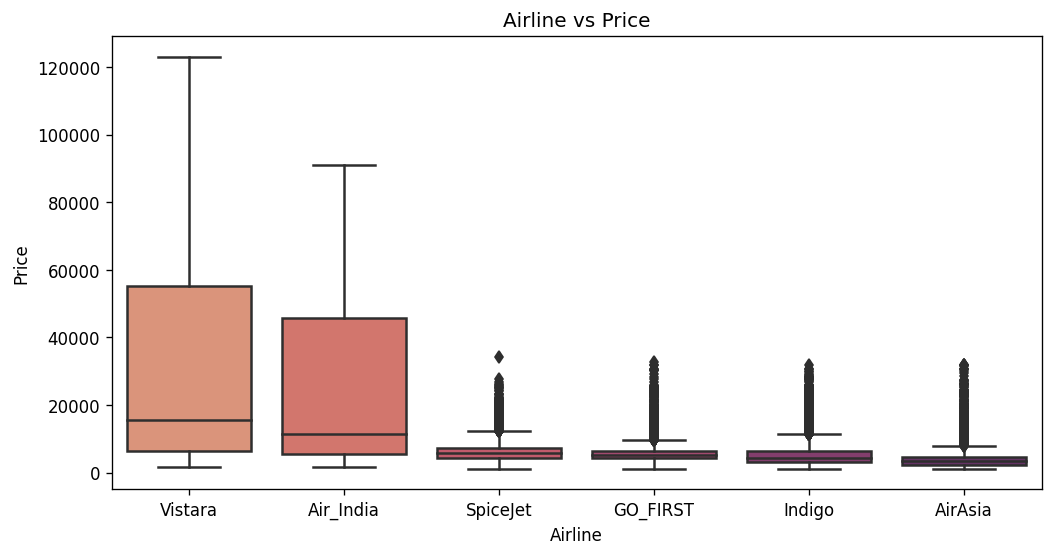

In [71]:
#Airline vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='price',x='airline',data = df.sort_values(by='price',ascending=False),palette='flare')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.title('Airline vs Price')
plt.show()

We can observe from the graph that Vistara and Air India have the highest prices. Apart from them, practically every airline has a comparable median price.

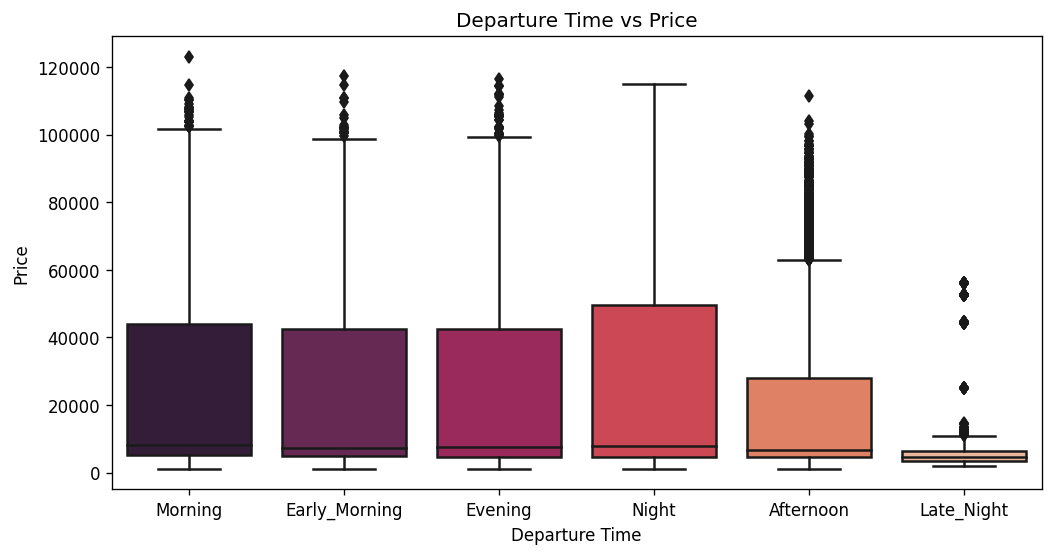

In [72]:
#Departure Time vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='price',x='departure_time',data = df.sort_values(by='price',ascending=False),palette='rocket')
plt.xlabel('Departure Time')
plt.ylabel('Price')
plt.title('Departure Time vs Price')
plt.show()

Median price is almost the same, but the price range for late night flights is small.

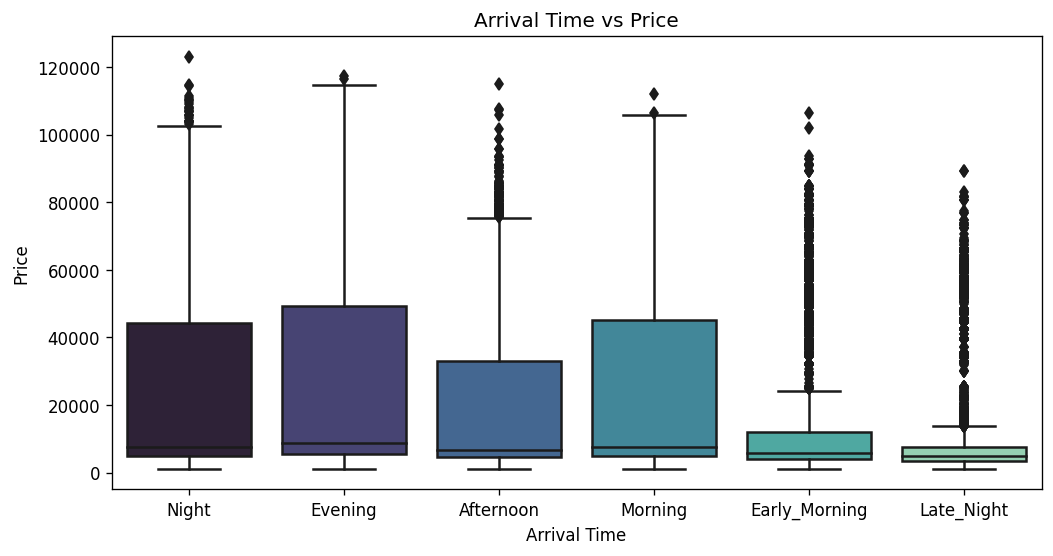

In [73]:
#Arrival Time vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='price',x='arrival_time',data = data.sort_values(by='price',ascending=False),palette='mako')
plt.xlabel('Arrival Time')
plt.ylabel('Price')
plt.title('Arrival Time vs Price')
plt.show()

Median price is almost the same, but the price range for late night flights is small.

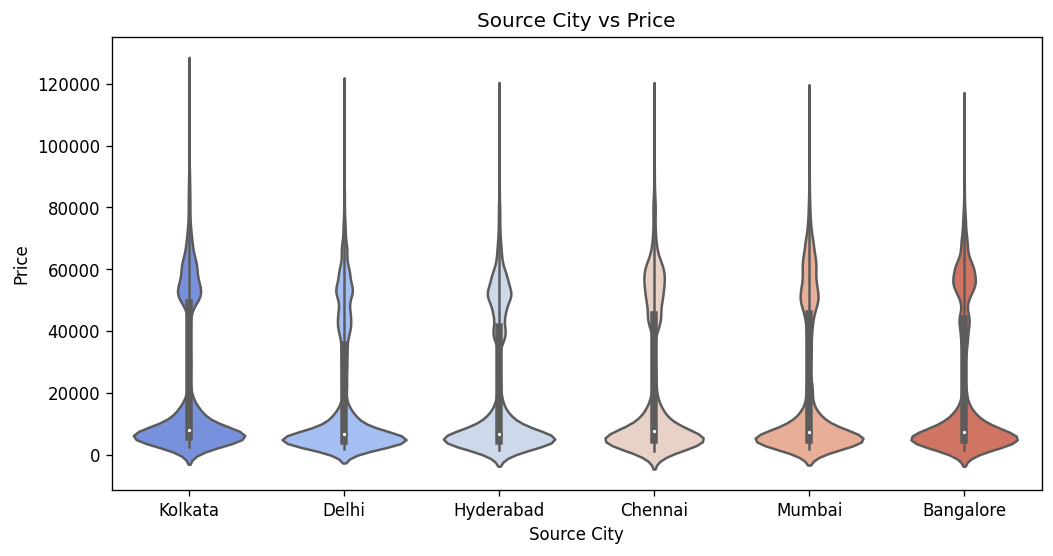

In [74]:
#Source City vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.violinplot(y='price',x='source_city',data = df.sort_values(by='price',ascending=False),palette='coolwarm')
plt.xlabel('Source City')
plt.ylabel('Price')
plt.title('Source City vs Price')
plt.show()

Median Price are almost same regardless of flight source city.



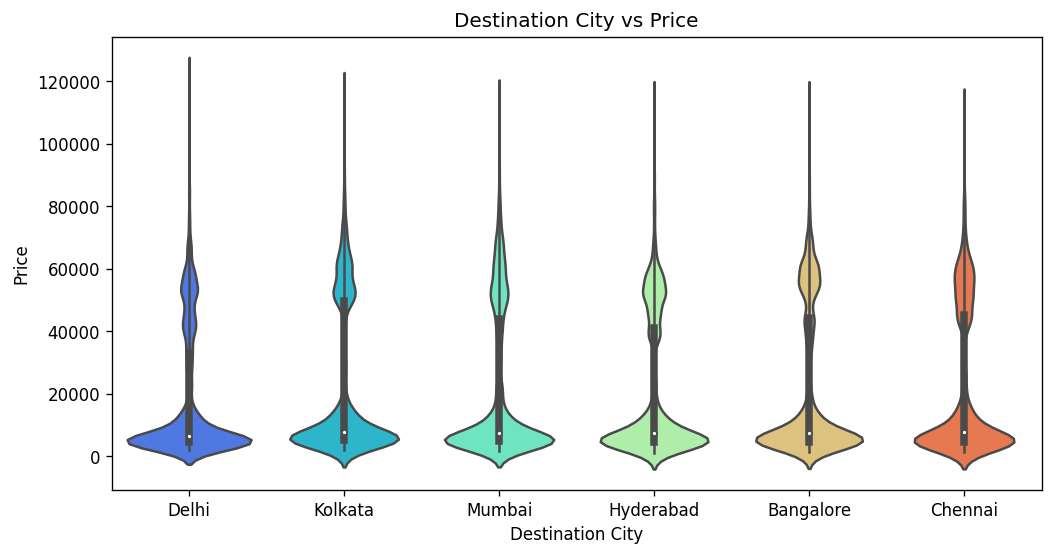

In [75]:
#Destination City vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.violinplot(y='price',x='destination_city',data = df.sort_values(by='price',ascending=False),palette='rainbow')
plt.xlabel('Destination City')
plt.ylabel('Price')
plt.title('Destination City vs Price')
plt.show()

Median Price are almost same regardless of flight destination city.



<Figure size 1200x600 with 0 Axes>

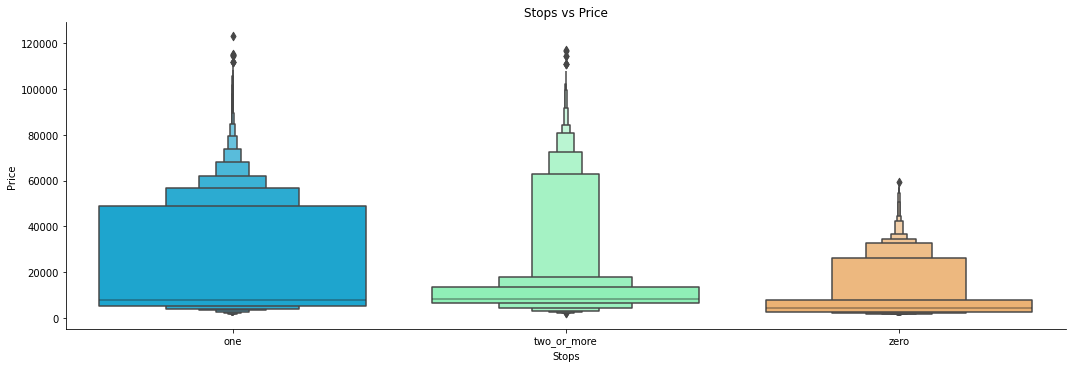

In [76]:
#Stops vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.catplot(y='price',x='stops',data = df.sort_values(by='price',ascending=False),palette='rainbow',kind ='boxen',height=5,aspect=3)
plt.xlabel('Stops')
plt.ylabel('Price')
plt.title('Stops vs Price')
plt.show()

Median Price are almost same.



<Figure size 1200x600 with 0 Axes>

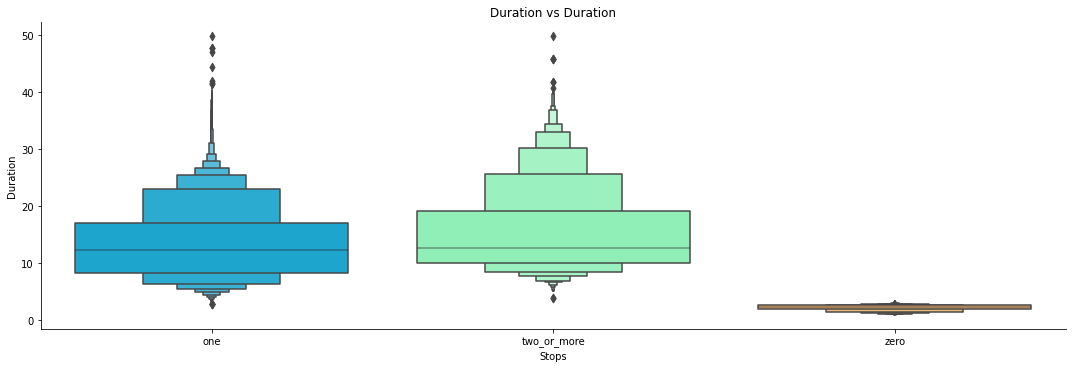

In [77]:
#Stops vs Duration
plt.figure(figsize=(10,5),dpi=120)
sns.catplot(y='duration',x='stops',data = df.sort_values(by='duration',ascending=False),palette='rainbow',kind ='boxen',height=5,aspect=3)
plt.xlabel('Stops')
plt.ylabel('Duration')
plt.title('Duration vs Duration')
plt.show()

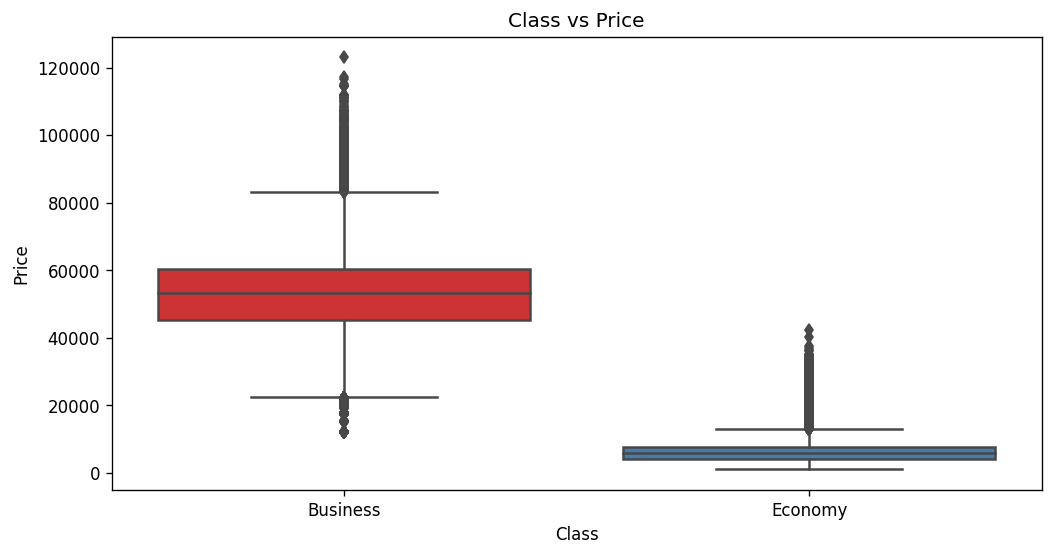

In [78]:
#Class vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='price',x='class',data = df.sort_values(by='price',ascending=False),palette='Set1')
plt.xlabel('Class')
plt.ylabel('Price')
plt.title('Class vs Price')
plt.show()

Business Class flight price is very high compared to economy class.

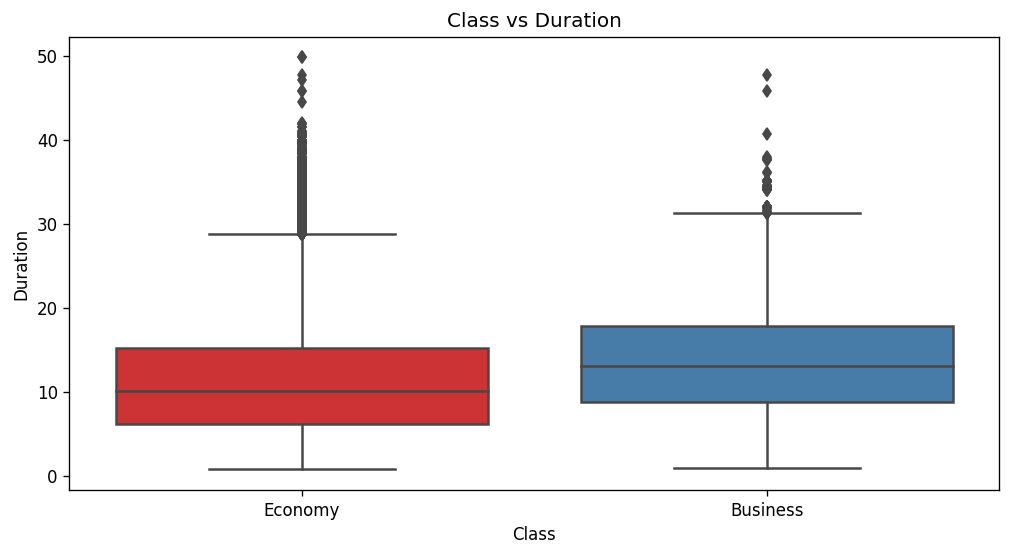

In [79]:
#Class vs Duration
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='duration',x='class',data = df.sort_values(by='duration',ascending=False),palette='Set1')
plt.xlabel('Class')
plt.ylabel('Duration')
plt.title('Class vs Duration')
plt.show()

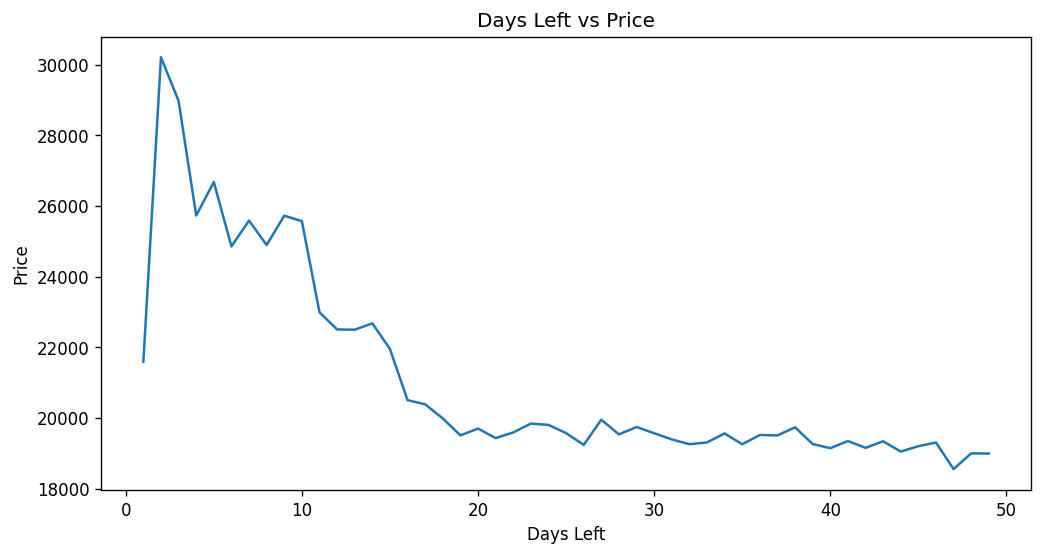

In [80]:
#Days_left vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.lineplot(x = df.groupby('days_left').mean().reset_index()['days_left'],y = df.groupby('days_left').mean().reset_index()['price'])
plt.xlabel('Days Left')
plt.ylabel('Price')
plt.title('Days Left vs Price')
plt.show()

The cost of a flight fluctuates greatly depending on how early you book it.
However, after a certain amount of time, it reaches saturation. 

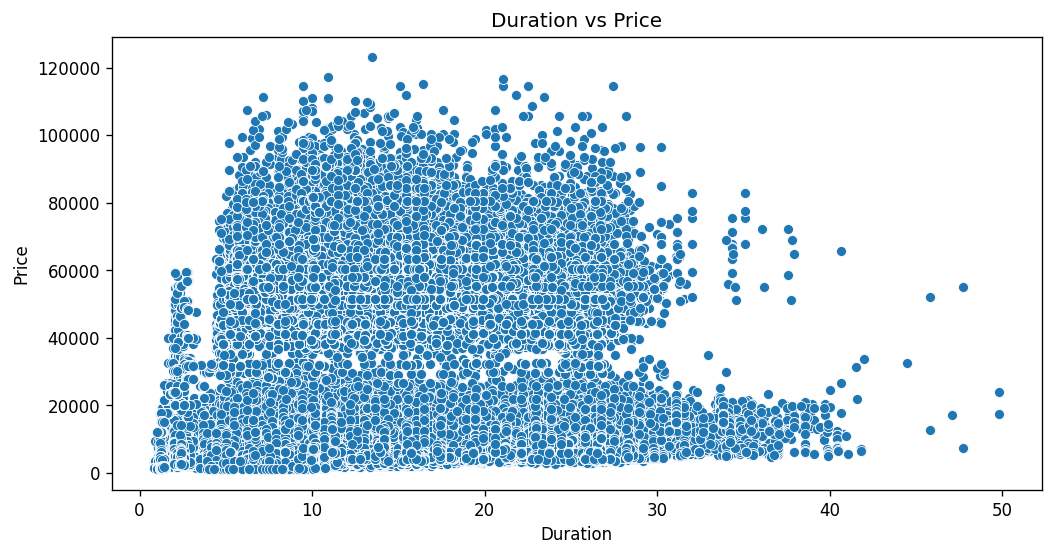

In [81]:
#Duration vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.scatterplot(y='price',x='duration',data = df,palette='viridis')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.title('Duration vs Price')
plt.show()

No Distinct Pattern observed

## Multivariate Analysis

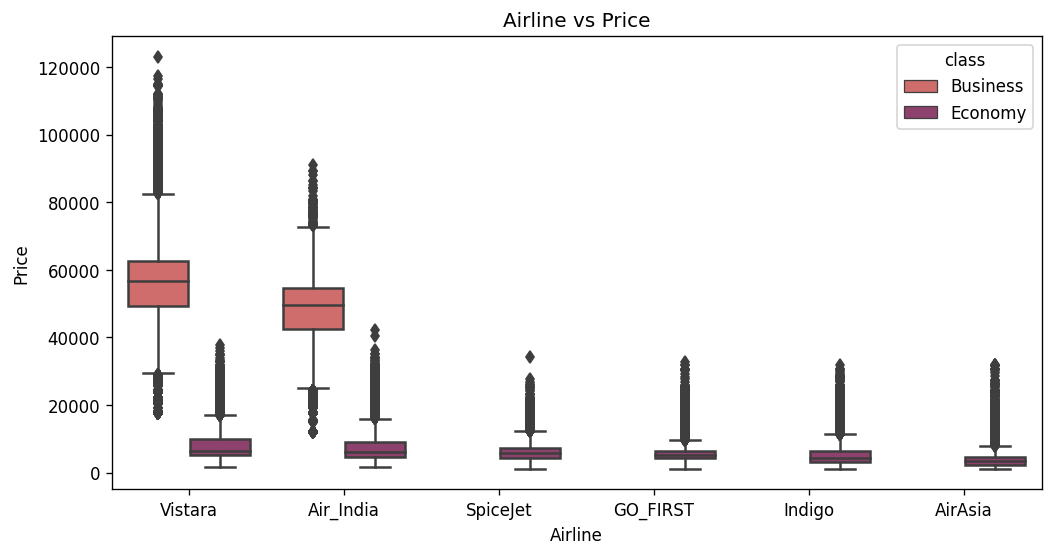

In [82]:
#Airline vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='price',x='airline',data = df.sort_values(by='price',ascending=False),palette='flare',hue='class')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.title('Airline vs Price')
plt.show()

In [83]:
df[df['class']=='Business']['airline'].value_counts()

Vistara      60589
Air_India    32898
Name: airline, dtype: int64

In India, Business class travel is only offered by Vistara and Air India Airlines. Due to which the relative mean price of the airlines increases.

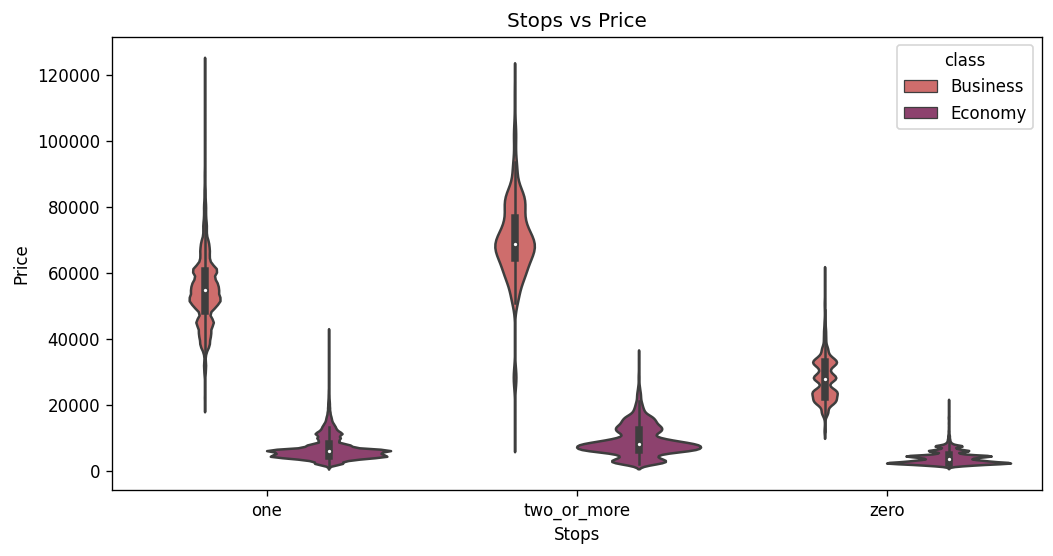

In [84]:
#Stops vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.violinplot(y='price',x='stops',data = df.sort_values(by='price',ascending=False),palette='flare',hue='class')
plt.xlabel('Stops')
plt.ylabel('Price')
plt.title('Stops vs Price')
plt.show()

# Hypothesis Testing

In [85]:
from scipy import stats

In [86]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Taking a sample of 3000 elements

In [87]:
random.seed(123)
sample_idx = random.sample(list(df.index),3000)

In [88]:
df_sample = df.iloc[sample_idx,:]

In [89]:
df_sample.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
27453,Vistara,UK-963,Delhi,Morning,one,Evening,Kolkata,Economy,8.00,42,6578
140339,Vistara,UK-772,Kolkata,Morning,one,Early_Morning,Bangalore,Economy,21.42,35,6195
45710,Vistara,UK-873,Mumbai,Early_Morning,one,Night,Delhi,Economy,16.50,16,5232
213511,Air_India,AI-504,Delhi,Night,zero,Late_Night,Bangalore,Business,2.92,21,32859
139750,Vistara,UK-776,Kolkata,Evening,one,Night,Bangalore,Economy,5.25,31,6841


##Compairing Sample and Population

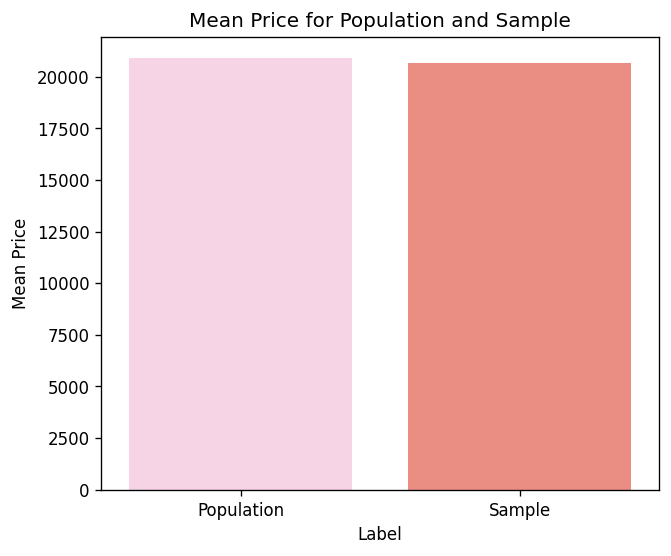

In [90]:
plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=[20889.66,20673.0],x=['Population','Sample'],palette = 'Set3_r')
plt.title('Mean Price for Population and Sample')
plt.xlabel('Label')
plt.ylabel('Mean Price')
plt.show()

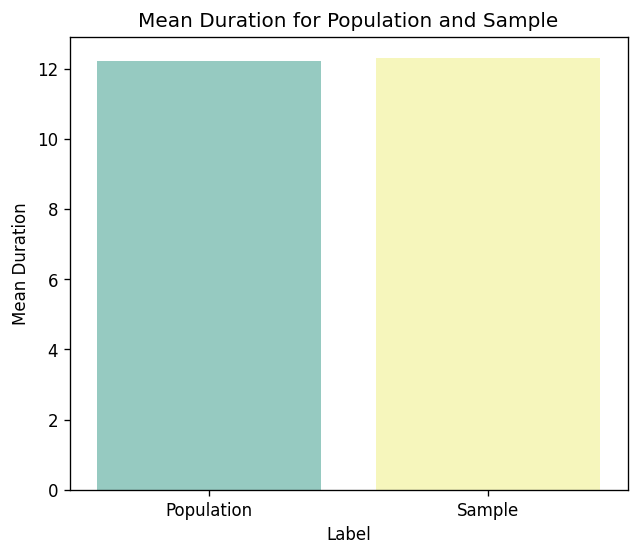

In [91]:
plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=[12.22,12.3],x=['Population','Sample'],palette = 'Set3')
plt.title('Mean Duration for Population and Sample')
plt.xlabel('Label')
plt.ylabel('Mean Duration')
plt.show()

In [92]:
print('Population Mean Price : ',round(df['price'].mean(),2),'\nSample Mean Price : ',round(df_sample['price'].mean(),2))
t_value,p_value=stats.ttest_1samp(a=df_sample['price'], popmean=df['price'].mean())
print('\nDoing t-test to compare means of sample and population\nNull Hypothesis: Mean Price are same.\nAlternate Hypothesis: Mean Price are different')
print(f'T-Statistics:{round(t_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis\n\n\n')
else:
  print('Reject the Null Hypothesis\n\n\n')

print('Population Mean Duration : ',round(df['duration'].mean(),2),'\nSample Mean Price : ',round(df_sample['duration'].mean(),2))
t_value,p_value=stats.ttest_1samp(a=df_sample['duration'], popmean=df['duration'].mean())
print('\nDoing t-test to compare means of sample and population\nNull Hypothesis: Mean Duration are same.\nAlternate Hypothesis: Mean Duration are different')
print(f'T-Statistics:{round(t_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')

Population Mean Price :  20889.66 
Sample Mean Price :  20673.0

Doing t-test to compare means of sample and population
Null Hypothesis: Mean Price are same.
Alternate Hypothesis: Mean Price are different
T-Statistics:-0.524, p-value:0.6
At 95% Confidence:
Failed to reject the Null Hypothesis



Population Mean Duration :  12.22 
Sample Mean Price :  12.3

Doing t-test to compare means of sample and population
Null Hypothesis: Mean Duration are same.
Alternate Hypothesis: Mean Duration are different
T-Statistics:0.571, p-value:0.5682
At 95% Confidence:
Failed to reject the Null Hypothesis


In [93]:
df_sample['class'].value_counts()/df_sample.shape[0]*100

Economy     69.533333
Business    30.466667
Name: class, dtype: float64

In [94]:
df['class'].value_counts()/df.shape[0]*100

Economy     68.853551
Business    31.146449
Name: class, dtype: float64

In [95]:
df_sample['stops'].value_counts()/df_sample.shape[0]*100

one            83.266667
zero           12.333333
two_or_more     4.400000
Name: stops, dtype: float64

In [96]:
df['stops'].value_counts()/df.shape[0]*100

one            83.578375
zero           11.995216
two_or_more     4.426409
Name: stops, dtype: float64

##T-Test

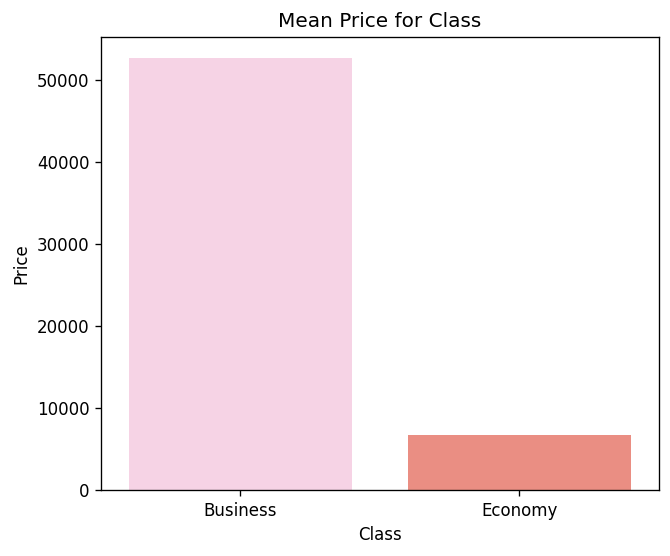

Doing t-test to compare means of the two class
Null Hypothesis: Mean Price for both class are same.
Alternate Hypothesis: Mean Price for both class are different
T-Statistics:-100.863, p-value:0.0
At 95% Confidence:
Reject the Null Hypothesis


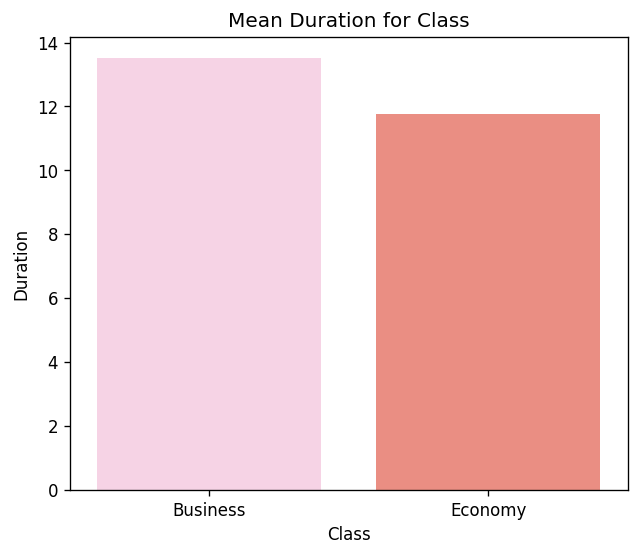

Doing t-test to compare means of the two class
Null Hypothesis: Mean Duration for both class are same.
Alternate Hypothesis: Mean Duration for both class are different
T-Statistics:-6.249, p-value:0.0
At 95% Confidence:
Reject the Null Hypothesis


In [97]:
#Class
plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=df_sample.groupby('class').mean()['price'],x=df_sample.groupby('class').mean().index,palette = 'Set3_r')
plt.title('Mean Price for Class')
plt.xlabel('Class')
plt.ylabel('Price')
plt.show()
t_value,p_value=stats.ttest_ind(df_sample[df_sample['class'] == 'Economy']['price'],df_sample[df_sample['class'] == 'Business']['price'],equal_var =False)
print('Doing t-test to compare means of the two class\nNull Hypothesis: Mean Price for both class are same.\nAlternate Hypothesis: Mean Price for both class are different')
print(f'T-Statistics:{round(t_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')

plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=df_sample.groupby('class').mean()['duration'],x=df_sample.groupby('class').mean().index,palette = 'Set3_r')
plt.title('Mean Duration for Class')
plt.xlabel('Class')
plt.ylabel('Duration')
plt.show()
t_value,p_value=stats.ttest_ind(df_sample[df_sample['class'] == 'Economy']['duration'],df_sample[df_sample['class'] == 'Business']['duration'],equal_var =False)
print('Doing t-test to compare means of the two class\nNull Hypothesis: Mean Duration for both class are same.\nAlternate Hypothesis: Mean Duration for both class are different')
print(f'T-Statistics:{round(t_value,3)}, p-value:{round(p_value,5)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')

In [98]:
df_sample['stops'] = df_sample['stops'].apply(lambda x : 'No' if x == 'zero' else 'Yes')

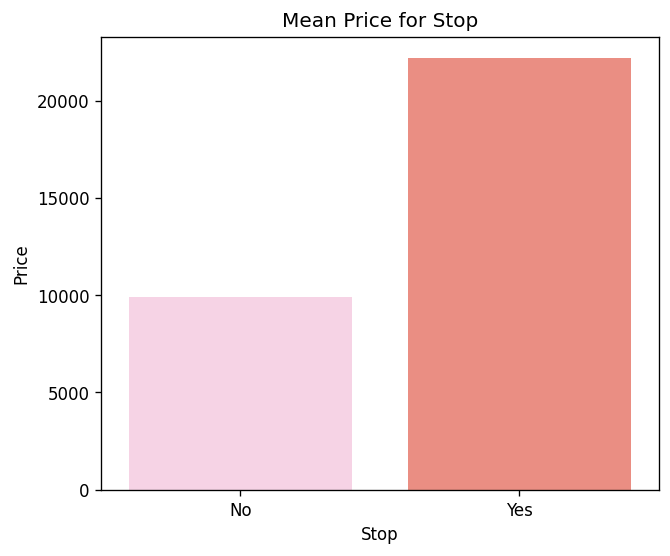

Doing t-test to compare means of the two stop
Null Hypothesis: Mean Price for both stop are same.
Alternate Hypothesis: Mean Price for both stop are different
T-Statistics:-16.637, p-value:0.0
At 95% Confidence:
Reject the Null Hypothesis


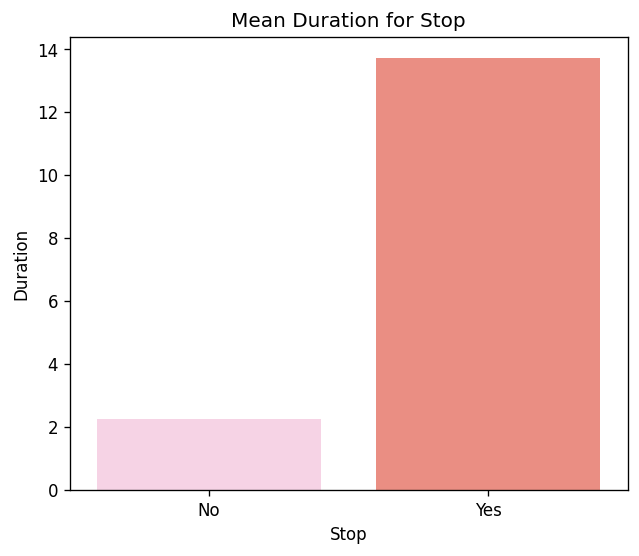

Doing t-test to compare means of the two stop
Null Hypothesis: Mean Duration for both stop are same.
Alternate Hypothesis: Mean Duration for both stop are different
T-Statistics:-86.988, p-value:0.0
At 95% Confidence:
Reject the Null Hypothesis


In [99]:
#Stop
plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=df_sample.groupby('stops').mean()['price'],x=df_sample.groupby('stops').mean().index,palette = 'Set3_r')
plt.title('Mean Price for Stop')
plt.xlabel('Stop')
plt.ylabel('Price')
plt.show()
t_value,p_value=stats.ttest_ind(df_sample[df_sample['stops'] == 'No']['price'],df_sample[df_sample['stops'] == 'Yes']['price'],equal_var =False)
print('Doing t-test to compare means of the two stop\nNull Hypothesis: Mean Price for both stop are same.\nAlternate Hypothesis: Mean Price for both stop are different')
print(f'T-Statistics:{round(t_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')

plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=df_sample.groupby('stops').mean()['duration'],x=df_sample.groupby('stops').mean().index,palette = 'Set3_r')
plt.title('Mean Duration for Stop')
plt.xlabel('Stop')
plt.ylabel('Duration')
plt.show()
t_value,p_value=stats.ttest_ind(df_sample[df_sample['stops'] == 'No']['duration'],df_sample[df_sample['stops'] == 'Yes']['duration'],equal_var =False)
print('Doing t-test to compare means of the two stop\nNull Hypothesis: Mean Duration for both stop are same.\nAlternate Hypothesis: Mean Duration for both stop are different')
print(f'T-Statistics:{round(t_value,3)}, p-value:{round(p_value,5)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')

##ANOVA

In [100]:
def get_mean(col):
  global df_sample
  price = df_sample.groupby(col).mean()['price']
  duration = df_sample.groupby(col).mean()['duration']
  price_idx = df_sample.groupby(col).mean()['price'].index
  duration_idx = df_sample.groupby(col).mean()['duration'].index
  return price,price_idx,duration,duration_idx

In [101]:
#print(df_sample[df_sample['airline'] == 'Air India']['price'])
#print(df_sample[df_sample['airline'] == 'AirAsia']['price'])
#print(df_sample[df_sample['airline'] == 'GO FIRST']['price'])
#print(df_sample[df_sample['airline'] == 'Indigo']['price'])
#print(df_sample[df_sample['airline'] == 'SpiceJet']['price'])
#print(df_sample[df_sample['airline'] == 'Vistara']['price'])

In [102]:
df_sample

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
27453,Vistara,UK-963,Delhi,Morning,Yes,Evening,Kolkata,Economy,8.00,42,6578
140339,Vistara,UK-772,Kolkata,Morning,Yes,Early_Morning,Bangalore,Economy,21.42,35,6195
45710,Vistara,UK-873,Mumbai,Early_Morning,Yes,Night,Delhi,Economy,16.50,16,5232
213511,Air_India,AI-504,Delhi,Night,No,Late_Night,Bangalore,Business,2.92,21,32859
139750,Vistara,UK-776,Kolkata,Evening,Yes,Night,Bangalore,Economy,5.25,31,6841
...,...,...,...,...,...,...,...,...,...,...,...
6941,Vistara,UK-829,Delhi,Early_Morning,Yes,Night,Mumbai,Economy,15.50,35,5227
18401,Vistara,UK-899,Delhi,Afternoon,Yes,Evening,Bangalore,Economy,4.75,42,3357
177332,Indigo,6E-752,Hyderabad,Early_Morning,Yes,Morning,Chennai,Economy,3.25,15,4836
165199,Vistara,UK-898,Hyderabad,Early_Morning,Yes,Morning,Mumbai,Economy,24.58,47,3571


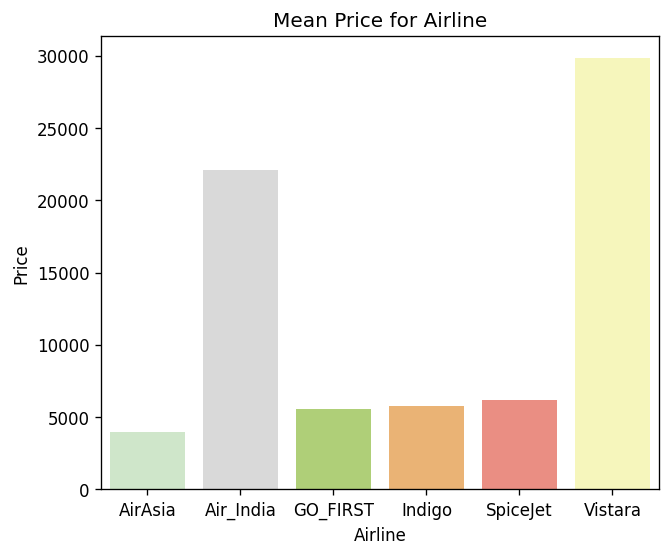

Anova test to compare means
Null Hypothesis: Mean Price for all airlines are same.
Alternate Hypothesis: Mean Price for all airlines are different
F-Statistics:156.179, p-value:0.0
At 95% Confidence:
Reject the Null Hypothesis


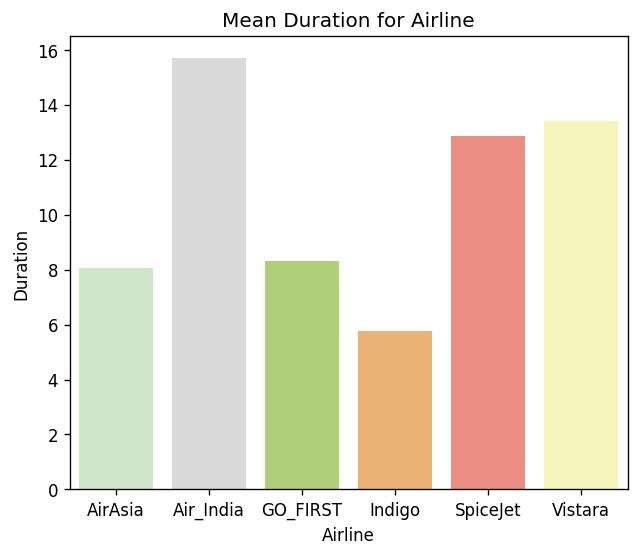

Anova test to compare means
Null Hypothesis: Mean Duration for all airlines are same.
Alternate Hypothesis: Mean Duration for all airlines are different
F-Statistics:165.807, p-value:0.0
At 95% Confidence:
Reject the Null Hypothesis


In [103]:
#Airline
price,price_idx,duration,duration_idx = get_mean('airline')
plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=price,x=price_idx,palette = 'Set3_r')
plt.title('Mean Price for Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.show()
f_value,p_value=stats.f_oneway(df_sample[df_sample['airline'] == 'Air_India']['price'],
                               df_sample[df_sample['airline'] == 'AirAsia']['price'],
                               df_sample[df_sample['airline'] == 'GO_FIRST']['price'],
                               df_sample[df_sample['airline'] == 'Indigo']['price'],
                               df_sample[df_sample['airline'] == 'SpiceJet']['price'],
                               df_sample[df_sample['airline'] == 'Vistara']['price'])
print('Anova test to compare means\nNull Hypothesis: Mean Price for all airlines are same.\nAlternate Hypothesis: Mean Price for all airlines are different')
print(f'F-Statistics:{round(f_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')
  

plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=duration,x=duration_idx,palette = 'Set3_r')
plt.title('Mean Duration for Airline')
plt.xlabel('Airline')
plt.ylabel('Duration')
plt.show()
f_value,p_value=stats.f_oneway(df_sample[df_sample['airline'] == 'Air_India']['duration'],
                               df_sample[df_sample['airline'] == 'AirAsia']['duration'],
                               df_sample[df_sample['airline'] == 'GO_FIRST']['duration'],
                               df_sample[df_sample['airline'] == 'Indigo']['duration'],
                               df_sample[df_sample['airline'] == 'SpiceJet']['duration'],
                               df_sample[df_sample['airline'] == 'Vistara']['duration'])
print('Anova test to compare means\nNull Hypothesis: Mean Duration for all airlines are same.\nAlternate Hypothesis: Mean Duration for all airlines are different')
print(f'F-Statistics:{round(f_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')

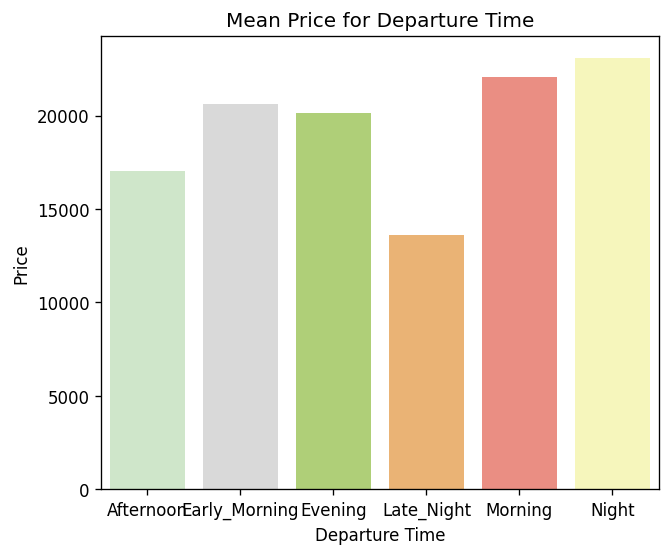

Anova test to compare means
Null Hypothesis: Mean Price for all Departure Time are same.
Alternate Hypothesis: Mean Price for all Departure Time are different
F-Statistics:4.362, p-value:0.0006
At 95% Confidence:
Reject the Null Hypothesis


In [104]:
#Departure
price,price_idx,duration,duration_idx = get_mean('departure_time')
plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=price,x=price_idx,palette = 'Set3_r')
plt.title('Mean Price for Departure Time')
plt.xlabel('Departure Time')
plt.ylabel('Price')
plt.show()

f_value,p_value=stats.f_oneway(df_sample[df_sample['departure_time'] == 'Early_Morning']['price'],
                               df_sample[df_sample['departure_time'] == 'Morning']['price'],
                               df_sample[df_sample['departure_time'] == 'Afternoon']['price'],
                               df_sample[df_sample['departure_time'] == 'Evening']['price'],
                               df_sample[df_sample['departure_time'] == 'Night']['price'],
                               df_sample[df_sample['departure_time'] == 'Late_Night']['price'])
print('Anova test to compare means\nNull Hypothesis: Mean Price for all Departure Time are same.\nAlternate Hypothesis: Mean Price for all Departure Time are different')
print(f'F-Statistics:{round(f_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')

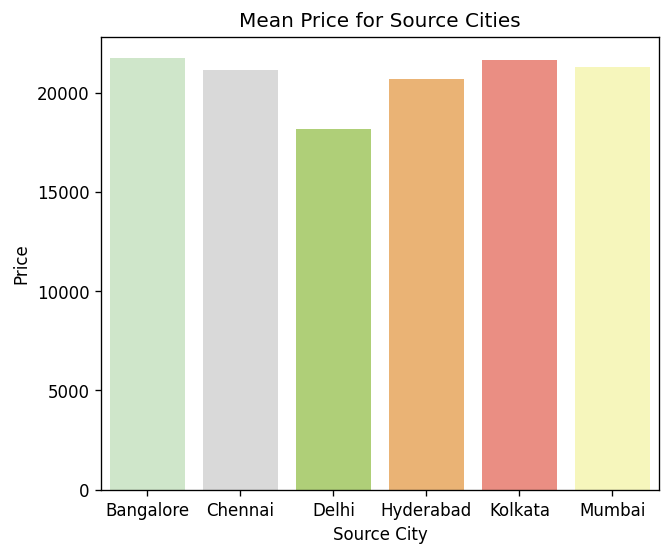

Anova test to compare means
Null Hypothesis: Mean Price for all source city are same.
Alternate Hypothesis: Mean Price for all source city are different
F-Statistics:2.045, p-value:0.0695
At 95% Confidence:
Failed to reject the Null Hypothesis


In [105]:
#Source
price,price_idx,duration,duration_idx = get_mean('source_city')
plt.figure(figsize=(6,5),dpi=120)
sns.barplot(y=price,x=price_idx,palette = 'Set3_r')
plt.title('Mean Price for Source Cities')
plt.xlabel('Source City')
plt.ylabel('Price')
plt.show()

f_value,p_value=stats.f_oneway(df_sample[df_sample['source_city'] == 'Delhi']['price'],
                               df_sample[df_sample['source_city'] == 'Mumbai']['price'],
                               df_sample[df_sample['source_city'] == 'Bangalore']['price'],
                               df_sample[df_sample['source_city'] == 'Kolkata']['price'],
                               df_sample[df_sample['source_city'] == 'Hyderabad']['price'],
                               df_sample[df_sample['source_city'] == 'Chennai']['price'])
print('Anova test to compare means\nNull Hypothesis: Mean Price for all source city are same.\nAlternate Hypothesis: Mean Price for all source city are different')
print(f'F-Statistics:{round(f_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
if p_value>0.05:
  print('Failed to reject the Null Hypothesis')
else:
  print('Reject the Null Hypothesis')

##Chi-Square

In [106]:
def chisquare(col1,col2):
  global df_sample
  data_crosstab = pd.crosstab(df_sample[col1],
                            df_sample[col2],
                           margins=True, margins_name="Total")
  print(data_crosstab,'\n')
  chi_value, p_value, dof, expected = stats.chi2_contingency(data_crosstab)

  print(f'Chi-Square test to check relationship\nNull Hypothesis:  The two categorical variables {col1} and {col2} have no relationship.\nAlternate Hypothesis: There is a relationship between two categorical variables {col1} and {col2}.')
  print(f'Chi-Statistics:{round(chi_value,3)}, p-value:{round(p_value,4)}\nAt 95% Confidence:')
  if p_value>0.05:
    print('Accept the Null Hypothesis\n\n\n')
  else:
    print('Reject the Null Hypothesis\n\n\n')

In [107]:
chisquare('airline','class')
chisquare('source_city','class')
chisquare('destination_city','class')
chisquare('departure_time','class')
chisquare('stops','class')


chisquare('airline','stops')
chisquare('source_city','stops')
chisquare('destination_city','stops')
chisquare('departure_time','stops')

chisquare('airline','departure_time')
chisquare('source_city','departure_time')
chisquare('destination_city','departure_time')

class      Business  Economy  Total
airline                            
AirAsia           0      163    163
Air_India       299      495    794
GO_FIRST          0      243    243
Indigo            0      392    392
SpiceJet          0       76     76
Vistara         615      717   1332
Total           914     2086   3000 

Chi-Square test to check relationship
Null Hypothesis:  The two categorical variables airline and class have no relationship.
Alternate Hypothesis: There is a relationship between two categorical variables airline and class.
Chi-Statistics:557.404, p-value:0.0
At 95% Confidence:
Reject the Null Hypothesis



class        Business  Economy  Total
source_city                          
Bangalore         159      363    522
Chennai           110      259    369
Delhi             180      442    622
Hyderabad         138      291    429
Kolkata           129      321    450
Mumbai            198      410    608
Total             914     2086   3000 

Chi-Square test to c

# Outlier Treatment

Price

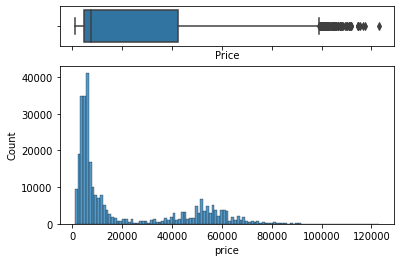

In [108]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
 
# assigning a graph to each ax
sns.boxplot(data=df, x="price", ax=ax_box)
sns.histplot(data=df, x="price", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='Price')
plt.show()

In [109]:
df['price'] = np.log(df['price'])

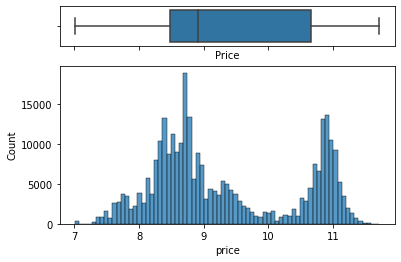

In [110]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
 
# assigning a graph to each ax
sns.boxplot(data=df, x="price", ax=ax_box)
sns.histplot(data=df, x="price", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='Price')
plt.show()

In [111]:
#med = np.median(df[df['class'] == 'Business']['price'])
#df.loc[abs((df['price'] - np.mean(df['price']))/np.std(df['price']))>3,'price'] = med

Duration

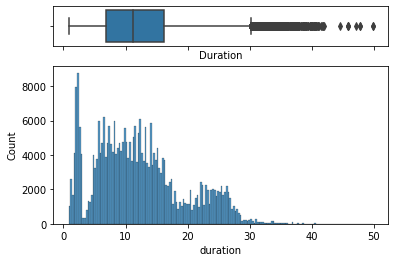

In [112]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
 
# assigning a graph to each ax
sns.boxplot(data=df, x="duration", ax=ax_box)
sns.histplot(data=df, x="duration", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='Duration')
plt.show()

In [113]:
df['duration'] = np.log(df['duration'])

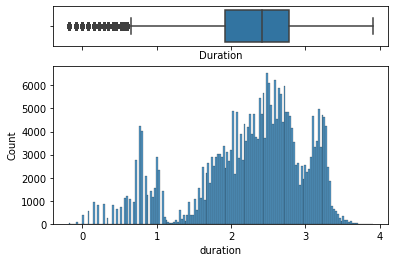

In [114]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
 
# assigning a graph to each ax
sns.boxplot(data=df, x="duration", ax=ax_box)
sns.histplot(data=df, x="duration", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='Duration')
plt.show()

In [115]:
med = np.median(df['duration'])
df.loc[abs((df['duration'] - np.mean(df['duration']))/np.std(df['duration']))>3,'duration'] = med

Days Left

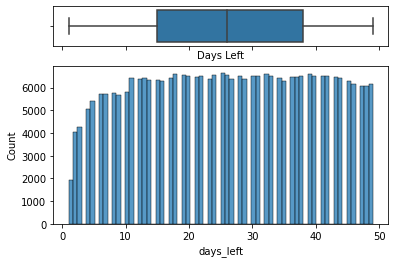

In [116]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
 
# assigning a graph to each ax
sns.boxplot(data=df, x="days_left", ax=ax_box)
sns.histplot(data=df, x="days_left", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='Days Left')
plt.show()

# Data Preprocessing

In [117]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,0.774727,1,8.691651
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,0.845868,1,8.691651
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,0.774727,1,8.692154
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,0.810930,1,8.691986
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,0.845868,1,8.691986


Dropping Column flight not telling anything

In [118]:
df.drop('flight',axis=1,inplace=True)

In [119]:
df.corr()

,duration,days_left,price
duration,1.000000,-0.025104,0.306697
days_left,-0.025104,1.000000,-0.193535
price,0.306697,-0.193535,1.000000


In [120]:
df = pd.get_dummies(df,drop_first=True)

In [121]:
standardized_df = df.copy()
normalized_df = df.copy()

In [122]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_df[['days_left','duration']] = scaler.fit_transform(standardized_df[['days_left','duration']])

In [123]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_df[['days_left','duration']] = scaler.fit_transform(normalized_df[['days_left','duration']])

# Linear Regression

In [ ]:
X = standardized_df.drop('price',axis=1)
y = standardized_df['price']

#X = normalized_df.drop('price',axis=1)
#y = normalized_df['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [ ]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

Multivariate Regression

In [ ]:
x = sm.add_constant(X)
model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 1.088e+05
Date:                Fri, 25 Feb 2022   Prob (F-statistic):               0.00
Time:                        06:05:08   Log-Likelihood:                -86668.
No. Observations:              300153   AIC:                         1.734e+05
Df Residuals:                  300122   BIC:                         1.737e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
resid = y_test-y_pred

In [ ]:
def rmse(model, y_test, y_pred, X_train):
 r_squared = round(model.score(X_test, y_test),4)
 mse = mean_squared_error(y_test, y_pred)
 rmse = round(np.sqrt(mse),4)
 mae = round(mean_absolute_error(y_test, y_pred),4)
 print('R-squared: ' + str(r_squared))
 print('Mean Absolute error: ', mae)
 print('Root Mean Squared Error: '+ str(rmse))

In [ ]:
rmse(reg,y_test,y_pred,X_train)

R-squared: 0.9158
Mean Absolute error:  0.2543
Root Mean Squared Error: 0.3229


AntiLog and then evaluating

In [ ]:
print('Actual Mean Absolute Error : ',abs(np.exp(y_test) - np.exp(y_pred)).mean())

Actual Mean Absolute Error :  4598.859268453865


## Assumptions Check

1. Linear Relationship
2. No Multicollinearity
3. Homoscedasticity
4. No Correlation between features and residuals
5. Normality of the Error Term
6. No Autocorrelation of Residuals

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from scipy.stats.stats import pearsonr
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as smt

### Linear Relationship

In [ ]:
def scatter_plot(y_test, y_pred, model_name):
  plt.figure(figsize=(10,6))
  sns.residplot(y_test, y_pred, lowess=True, color='#4682b4',
            line_kws={'lw': 2, 'color': 'r'})
  plt.title(str('Residuals Plot for ' + model_name))
  plt.xlabel('Predicted Log Price',fontsize=16)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.show()

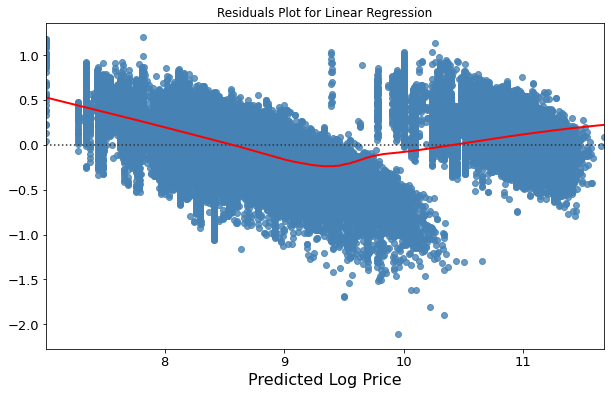

In [ ]:
scatter_plot(y_test,y_pred,"Linear Regression")

Points are assymmetrically distributed around the horizontal line in the Residual vs Predicted.<br>The inspection of the plot shows that the linearity assumption is not satisfied.

In [ ]:
print('Mean of residuals : ',resid.mean())

Mean of residuals :  -0.0009325520886841913


Very Small, Can be assumed to be zero

###Multicollinearity

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                         feature       VIF
0                       duration  3.359939
1                      days_left  1.005038
2              airline_Air_India  4.504380
3               airline_GO_FIRST  1.941750
4                 airline_Indigo  2.884173
5               airline_SpiceJet  1.440922
6                airline_Vistara  6.294949
7            source_city_Chennai  1.703086
8              source_city_Delhi  2.080835
9          source_city_Hyderabad  1.749821
10           source_city_Kolkata  1.824639
11            source_city_Mumbai  2.135744
12  departure_time_Early_Morning  2.237199
13        departure_time_Evening  2.324833
14     departure_time_Late_Night  1.047184
15        departure_time_Morning  2.336193
16          departure_time_Night  2.036714
17             stops_two_or_more  1.114533
18                    stops_zero  3.138568
19    arrival_time_Early_Morning  1.405980
20          arrival_time_Evening  2.771093
21       arrival_time_Late_Night  1.332107
22         

All Below 10, No Multicollinearity

###Homoscedasticity

White’s test uses the following null and alternative hypotheses:

1. Null (H0): Homoscedasticity is present (residuals are equally scattered)
2. Alternative (HA): Heteroscedasticity is present (residuals are not equally scattered)


In [ ]:
white_test = het_white(model.resid,  model.model.exog)

In [ ]:
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test)))

{'Test Statistic': 48486.187869696, 'Test Statistic p-value': 0.0, 'F-Statistic': 143.29953751437176, 'F-Test p-value': 0.0}


Rejecting the Null Hypohesis, Heteroscedascticity is present

###Correlation between Features and Residual

In [ ]:
for column in X.columns:
    corr_test = pearsonr(X[column], model.resid)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

Variable: duration --- correlation: 0.0000, p-value: 1.0000
Variable: days_left --- correlation: 0.0000, p-value: 1.0000
Variable: airline_Air_India --- correlation: 0.0000, p-value: 1.0000
Variable: airline_GO_FIRST --- correlation: -0.0000, p-value: 1.0000
Variable: airline_Indigo --- correlation: -0.0000, p-value: 1.0000
Variable: airline_SpiceJet --- correlation: -0.0000, p-value: 1.0000
Variable: airline_Vistara --- correlation: 0.0000, p-value: 1.0000
Variable: source_city_Chennai --- correlation: 0.0000, p-value: 1.0000
Variable: source_city_Delhi --- correlation: -0.0000, p-value: 1.0000
Variable: source_city_Hyderabad --- correlation: 0.0000, p-value: 1.0000
Variable: source_city_Kolkata --- correlation: -0.0000, p-value: 1.0000
Variable: source_city_Mumbai --- correlation: -0.0000, p-value: 1.0000
Variable: departure_time_Early_Morning --- correlation: 0.0000, p-value: 1.0000
Variable: departure_time_Evening --- correlation: -0.0000, p-value: 1.0000
Variable: departure_time_L

No Correlation Found

###Normality of the Error Term

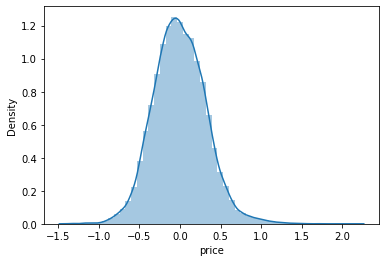

In [ ]:
sns.distplot(resid)

Jarque-Bera test ---- statistic: 10159.1824, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9942, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.2580, p-value: 0.0000


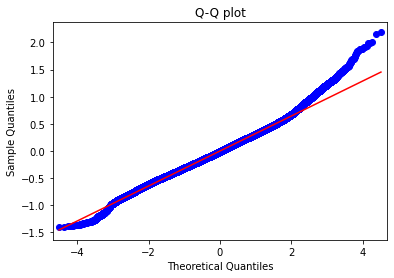

In [ ]:
def normality_of_residuals_test(model):

    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    
normality_of_residuals_test(model)

From the results above we can infer that the residuals do not follow Gaussian distribution<br>From the shape of the QQ plot, as well as rejecting the null hypothesis in all statistical tests.

###Autocorrelation of the Residuals

In [ ]:
durbinWatson = durbin_watson(resid)

In [ ]:
print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: 2.009205391097966
Little to no autocorrelation 

Assumption satisfied


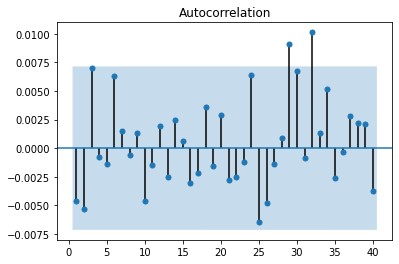

In [ ]:
acf = smt.graphics.plot_acf(resid, lags=40 ,zero= False)
acf.show()

Liitle to no Autocorrelation

##Stepwise Regression

In [ ]:
col_best = []
full_list = []
adj = []

while len(col_best)<=X.shape[1]:
  best_adj_r2 = 0
  for col in list(set(X.columns) - set(col_best)):
      new_best = col_best.copy()
      new_best.append(col)
      x = sm.add_constant(X[new_best])
      adj_r2 = sm.OLS(y,x).fit().rsquared_adj
      if best_adj_r2<adj_r2:
          best_adj_r2 = adj_r2
          best_col = col
          full = x.columns[1:]
  col_best.append(best_col)
  full_list.append(list(full))
  adj.append(best_adj_r2)

In [ ]:
df_step_reg = pd.DataFrame({'No_of_Features':np.arange(1,31),'Adj_R2':adj[:-1],'Variables':full_list[:-1]})

In [ ]:
df_step_reg

,No_of_Features,Adj_R2,Variables
0,1,0.825600,[class_Economy]
1,2,0.858616,"[class_Economy, days_left]"
2,3,0.887732,"[class_Economy, days_left, duration]"
3,4,0.895512,"[class_Economy, days_left, duration, airline_V..."
4,5,0.899237,"[class_Economy, days_left, duration, airline_V..."
5,6,0.902316,"[class_Economy, days_left, duration, airline_V..."
6,7,0.904768,"[class_Economy, days_left, duration, airline_V..."
7,8,0.907086,"[class_Economy, days_left, duration, airline_V..."
8,9,0.908155,"[class_Economy, days_left, duration, airline_V..."
9,10,0.909145,"[class_Economy, days_left, duration, airline_V..."


We notice that only 10 independent variables explain almost 90.9% of the variability in target variable.<br>And only 0.7% of extra variability is explained by adding other 20 variables.

In [ ]:
list(df_step_reg[df_step_reg['No_of_Features']==10]['Variables'])

[['class_Economy',
  'days_left',
  'duration',
  'airline_Vistara',
  'stops_zero',
  'airline_Air_India',
  'source_city_Kolkata',
  'destination_city_Kolkata',
  'stops_two_or_more',
  'airline_GO_FIRST']]

In [ ]:
x = sm.add_constant(X[['class_Economy',
  'days_left',
  'duration',
  'airline_Vistara',
  'stops_zero',
  'airline_Air_India',
  'source_city_Kolkata',
  'destination_city_Kolkata',
  'stops_two_or_more',
  'airline_GO_FIRST']])

model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 3.003e+05
Date:                Fri, 25 Feb 2022   Prob (F-statistic):               0.00
Time:                        06:11:08   Log-Likelihood:                -98013.
No. Observations:              300153   AIC:                         1.960e+05
Df Residuals:                  300142   BIC:                         1.962e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
print('Mean Absolute Error : ',abs(model.resid).mean())
print('Root Mean Squared Error : ',np.sqrt(((model.resid)**2).mean()))

Mean Absolute Error :  0.26323902322709436
Root Mean Squared Error :  0.33541207995385613


#Model Building

In [ ]:
random.seed(123)

In [ ]:
sample_idx = random.sample(list(standardized_df.index),10000)
df_sample = standardized_df.iloc[sample_idx,:]

#sample_idx = random.sample(list(normalized_df.index),10000)
#df_sample = normalized_df.iloc[sample_idx,:]

In [ ]:
X = df_sample.drop('price',axis=1)
y = df_sample['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3,test_size=0.25)

In [ ]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators = 500)
xg = XGBRegressor(n_estimators = 500)

In [ ]:
print(cross_val_score(estimator=lr, X=X, y=y, cv=5, scoring='neg_mean_squared_error'))

[-0.10281936 -0.10676455 -0.10500029 -0.10588632 -0.10546968]


In [ ]:
print(cross_val_score(estimator=rf, X=X, y=y, cv=5, scoring='neg_mean_squared_error'))

[-0.0506231  -0.04773103 -0.04584651 -0.04827511 -0.04817927]


In [ ]:
print(cross_val_score(estimator=xg, X=X, y=y, cv=5, scoring='neg_mean_squared_error'))

[-0.05233961 -0.05217459 -0.05010443 -0.05113056 -0.05255425]


## Lazy Learner

In [ ]:
!pip install pyforest
!pip install lazypredict

In [ ]:
# Importing important libraries
import pyforest
from lazypredict.Supervised import LazyRegressor
from pandas.plotting import scatter_matrix# Scikit-learn packages
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error# Hide warnings
import warnings
warnings.filterwarnings("ignore") # Setting up max columns displayed to 100
pd.options.display.max_columns = 100

In [ ]:
reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 42/42 [01:37<00:00,  2.32s/it]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.96       0.96  0.22        3.33
XGBRegressor                                 0.96       0.96  0.22        1.13
ExtraTreesRegressor                          0.96       0.96  0.23        3.17
LGBMRegressor                                0.96       0.96  0.23        0.25
HistGradientBoostingRegressor                0.96       0.96  0.23        6.17
BaggingRegressor                             0.96       0.96  0.23        0.79
SVR                                          0.95       0.95  0.25        5.78
NuSVR                                        0.95       0.95  0.25        8.92
GradientBoostingRegressor                    0.94       0.94  0.26        2.10
MLPRegressor                                 0.93       0.94  0.28        9.87
ExtraTreeRegressor                           0.93   

In [ ]:
def rmse(model, y_test, y_pred, X_train, y_train):
 r_squared = model.score(X_test, y_test)
 mse = mean_squared_error(y_test, y_pred)
 rmse = np.sqrt(mse)
 print('R-squared: ' + str(r_squared))
 print('Mean Squared Error: '+ str(rmse))# Create model line scatter plot

def scatter_plot(y_test, y_pred, model_name):
    plt.figure(figsize=(10,6))
    sns.residplot(y_test, y_pred, lowess=True, color='#4682b4',
              line_kws={'lw': 2, 'color': 'r'})
    plt.title(str('Log Price vs Residuals for '+ model_name))
    plt.xlabel('Log Price',fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.show()

In [ ]:
xg = XGBRegressor()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

In [ ]:
rmse(xg,y_test,y_pred,X_train,y_train)

R-squared: 0.9581439124457269
Mean Squared Error: 0.22269357335138698


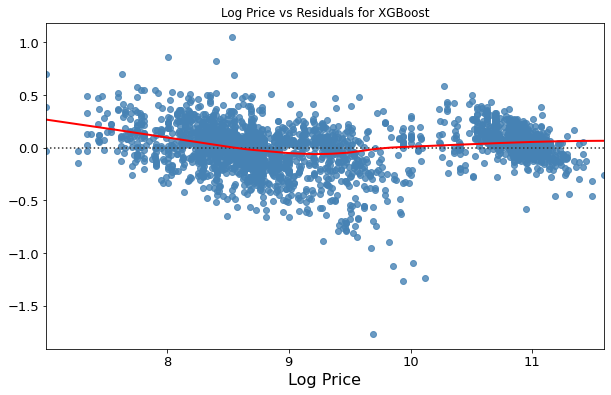

In [ ]:
scatter_plot(y_test,y_pred,"XGBoost")

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [ ]:
rmse(rf,y_test,y_pred,X_train,y_train)

R-squared: 0.9597770468706261
Mean Squared Error: 0.21830583559202227


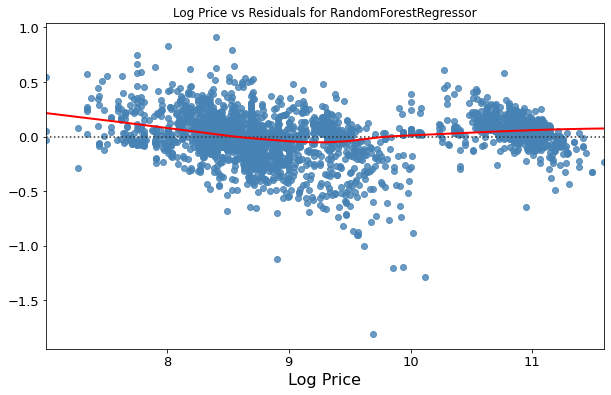

In [ ]:
scatter_plot(y_test,y_pred,"RandomForestRegressor")

#

##Randomized Search 

In [ ]:
'''
xg_param_grid = params = { 'max_depth': [3, 5, 6, 10, 15, 20],
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

'colsample_bylevel': 0.7,
 'colsample_bytree': 0.7999999999999999,
 'learning_rate': 0.01,
 'max_depth': 15,
 'n_estimators': 1000,
 'subsample': 0.7
'''        

"\nxg_param_grid = params = { 'max_depth': [3, 5, 6, 10, 15, 20],\n          'learning_rate': [0.01, 0.1, 0.2, 0.3],\n           'subsample': np.arange(0.5, 1.0, 0.1),\n           'colsample_bytree': np.arange(0.4, 1.0, 0.1),\n           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),\n           'n_estimators': [100, 500, 1000]}\n\n'colsample_bylevel': 0.7,\n 'colsample_bytree': 0.7999999999999999,\n 'learning_rate': 0.01,\n 'max_depth': 15,\n 'n_estimators': 1000,\n 'subsample': 0.7\n"

In [ ]:
xg_param_grid = params = { 'max_depth': [12, 15, 17],
           'learning_rate': np.arange(0.01, 0.1, 0.01),
           'subsample': np.arange(0.6, 0.8, 0.1),
           'colsample_bytree': np.arange(0.7, 0.9, 0.1),
           'colsample_bylevel': np.arange(0.6,0.8, 0.1),
           'n_estimators': [1000,1200]}   

'''
'colsample_bylevel': 0.6,
 'colsample_bytree': 0.7,
 'learning_rate': 0.02,
 'max_depth': 12,
 'n_estimators': 1000,
 'subsample': 0.6
'''

"\n'colsample_bylevel': 0.6,\n 'colsample_bytree': 0.8999999999999999,\n 'learning_rate': 0.01,\n 'max_depth': 12,\n 'n_estimators': 1000,\n 'subsample': 0.7\n"

In [ ]:
xgbr = XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=xg_param_grid,
                         scoring='neg_mean_squared_error',
                         n_iter=50,
                         verbose=1,n_jobs=-1,cv=3)
clf.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 45.6min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50, n_jobs=-1,
                   par

In [ ]:
clf.best_params_

{'colsample_bylevel': 0.6,
 'colsample_bytree': 0.7,
 'learning_rate': 0.02,
 'max_depth': 12,
 'n_estimators': 1000,
 'subsample': 0.6}

In [ ]:
xg = XGBRegressor(colsample_bylevel= 0.6,colsample_bytree= 0.7,learning_rate= 0.02,max_depth = 12,n_estimators= 1000,subsample= 0.6)
print(cross_val_score(estimator=xg, X=X, y=y, cv=5, scoring='neg_mean_squared_error'))

#[-0.04869623 -0.04567035 -0.0428654  -0.04327152 -0.047303  ]

[-0.04869623 -0.04567035 -0.0428654  -0.04327152 -0.047303  ]


In [ ]:
'''
rf_param_grid ={
    'max_depth':[30,40,55,75,100,130],
    'n_estimators': [250,350,500,700,900],
    'bootstrap':[True,False],
    'max_features':['auto','sqrt'],
    'min_samples_leaf': [1,2,4,7,10],
    'min_samples_split': [7, 10, 14,17],
}

'bootstrap': True,
 'max_depth': 55,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 900

'''

"\nrf_param_grid ={\n    'max_depth':[30,40,55,75,100,130],\n    'n_estimators': [250,350,500,700,900],\n    'bootstrap':[True,False],\n    'max_features':['auto','sqrt'],\n    'min_samples_leaf': [1,2,4,7,10],\n    'min_samples_split': [7, 10, 14,17],\n}\n\n'bootstrap': True,\n 'max_depth': 55,\n 'max_features': 'auto',\n 'min_samples_leaf': 1,\n 'min_samples_split': 7,\n 'n_estimators': 900\n\n"

In [ ]:
rf_param_grid ={
    'max_depth':[45,55,75],
    'n_estimators': [800,900,1100],
    'bootstrap':[True],
    'max_features':['auto'],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [1,3,5,7,9],
}

'''
'bootstrap': True,
 'max_depth': 45,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1100
'''

"\n'bootstrap': True,\n 'max_depth': 75,\n 'max_features': 'auto',\n 'min_samples_leaf': 1,\n 'min_samples_split': 3,\n 'n_estimators': 800\n"

In [ ]:
rf=RandomForestRegressor()
rf_random=RandomizedSearchCV(estimator=rf,param_distributions=rf_param_grid,cv=3,verbose=2,n_jobs=-1)
rf_random.fit(X,y)
# best parameter
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.3min finished


{'bootstrap': True,
 'max_depth': 45,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1100}

In [ ]:
rf = RandomForestRegressor(bootstrap=True, max_depth= 45, max_features= 'auto', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 1100)
print(cross_val_score(estimator=rf, X=X, y=y, cv=5, scoring='neg_mean_squared_error'))

#[-0.05027666 -0.04791623 -0.0460206  -0.04847639 -0.04835251]

[-0.05027666 -0.04791623 -0.0460206  -0.04847639 -0.04835251]


Tuned Xg Boost giving better result

## Bayesian - Hyperopt

In [ ]:
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials

In [ ]:
rf_param_grid ={
    'max_depth':hp.choice('max_depth',range(35,100)),
    'n_estimators': hp.choice('n_estimators',range(250,1000)),
    'bootstrap':hp.choice('bootstrap',[True]),
    'max_features':hp.choice('max_features',['auto']),
    'min_samples_leaf': hp.choice('min_samples_leaf',range(1,5)),
    'min_samples_split': hp.choice('min_samples_split',range(1,5))  

}

In [ ]:
def hyperopt_obj_function(params):
    rf=RandomForestRegressor(**params)
    out = cross_val_score(rf, X_train,y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=-1).mean()
    return out

In [ ]:
def surrogate_function(params):
    perf = hyperopt_obj_function(params)
    return {'loss':-perf, 'status':STATUS_OK}

In [ ]:
trials = Trials()
best = fmin(surrogate_function, space=rf_param_grid, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:')
print (best)

100%|██████████| 100/100 [17:35<00:00, 10.55s/it, best loss: 0.05155164283214232]


AssertionError: ignored

#Final Model

In [ ]:
X = standardized_df.drop('price',axis=1)
y = standardized_df['price']

In [ ]:
xg = XGBRegressor(colsample_bylevel= 0.6,colsample_bytree= 0.7,learning_rate= 0.02,max_depth = 12,n_estimators= 1000,subsample= 0.6)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [ ]:
xg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred = xg.predict(X_test)

In [ ]:
rmse(xg,y_test,y_pred,X_train)

R-squared: 0.9844
Mean Absolute error:  0.0875
Root Mean Squared Error: 0.1392


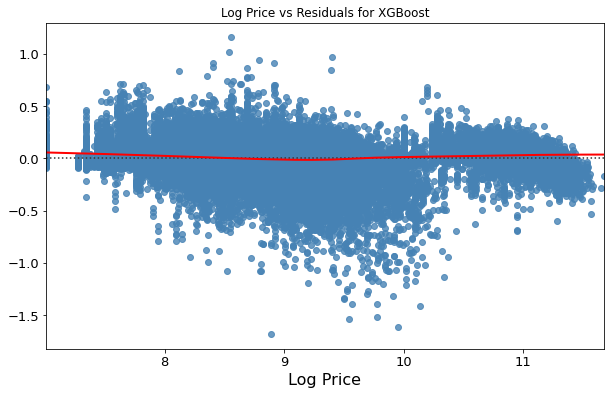

In [ ]:
scatter_plot(y_test,y_pred,"XGBoost")

In [ ]:
print('Actual Mean Absolute Error : ',abs(np.exp(y_test) - np.exp(y_pred)).mean())

Actual Mean Absolute Error :  1383.7177626472126


In [ ]:
#Much Better compared to linear regression